<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr1/blob/main/Kozlov%20Alexey/InspectrumClinic_gr1_akozlov_20230619_07week_new_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Рекомендательная система для профпатолога (INSPECTRUM CLINIC)**

Алексей Козлов 2023.06.19 - 2023.06.26 (7-я неделя): Подбор гиперпараметров, снабжение тектовыми блоками с описанием этапов/экспериментов и выводами

# ТЕХНИЧЕСКОЕ ЗАДАНИЕ

**Рекомендательная система для профпатолога (INSPECTRUM CLINIC)**

**Цель:**

Разработать прототип системы, реализующей функцию рекомендательной системы для врача профпатолога.


**Принцип работы:**

1.   Система должна помогать врачу вынести решение о том годен, не годен или ограниченно годен человек на определенной должности.
2.   В датасете целевым столбцом для предсказания нейросетью является столбец под названием: “ЗаключениеМК”.
3.   Система может дополнять вердикт мнением, почему человек не годен, или почему ограниченно годен.


**Требования интерфейсу:**


*Минимальный уровень реализации:*

notebook google colaboratory. Требуется реализовать простой веб-интерфейс для загрузки анализируемого моделью нейросети набора данных и удобным выводом результатов вынесенного решения.

*Дополнительно:*

передача продвинутой системы веб-интерфейса, дополняющей вердикт мнением, почему человек не годен, или почему ограниченно годен.

**Требования к скорости работы:**

Не предъявляются

**Требования к тестированию, метрикам качества:**

Оценка результатов работы системы производится Заказчиком на тестовом наборе Заказчика. Метрика точности - точность рекомендации должна быть не ниже 95%.


# Импорт библиотек

In [1]:
# Загрузка файлов из облака
import gdown
# Библиотека для работы с массивами данных
import numpy as np
# Библиотека для обработки и анализа данных
import pandas as pd
# Библиотека для построения графиков
import matplotlib.pyplot as plt
# Команда для отображения графики в ячейках среды Google Colaboratory
%matplotlib inline
# Библиотека для построения графиков
import seaborn as sns
#Для генерации случайных чисел
import random
# Для округления
import math
import re

# Подключение класса создания модели Sequential
# Sequential – модуль для создания последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model
# Подключение класса Dense - полносвязный слой
# Dense – линейный (полносвязный) слой. Из таких слоев будет создана ваша нейросеть
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
# utils – модуль с полезными инструментами для подготовки данных
#Используем для to_categoricall
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
# подключаем колбэки
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.preprocessing import StandardScaler
# Для разбивки на выборки
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from IPython.display import clear_output

# Для работы с датами
from datetime import datetime

#from keras import metrics

# Приказ Министерства здравоохранения Российской Федерации от 28.01.2021 №29Н

https://normativ.kontur.ru/document?moduleId=1&documentId=416520

"МИНИСТЕРСТВО ЗДРАВООХРАНЕНИЯ РОССИЙСКОЙ ФЕДЕРАЦИИ
ПРИКАЗ
от 28 января 2021 г. N 29н
ОБ УТВЕРЖДЕНИИ ПОРЯДКА ПРОВЕДЕНИЯ ОБЯЗАТЕЛЬНЫХ ПРЕДВАРИТЕЛЬНЫХ И ПЕРИОДИЧЕСКИХ МЕДИЦИНСКИХ ОСМОТРОВ РАБОТНИКОВ, ПРЕДУСМОТРЕННЫХ ЧАСТЬЮ ЧЕТВЕРТОЙ СТАТЬИ 213 ТРУДОВОГО КОДЕКСА РОССИЙСКОЙ ФЕДЕРАЦИИ, ПЕРЕЧНЯ МЕДИЦИНСКИХ ПРОТИВОПОКАЗАНИЙ К ОСУЩЕСТВЛЕНИЮ РАБОТ С ВРЕДНЫМИ И (ИЛИ) ОПАСНЫМИ ПРОИЗВОДСТВЕННЫМИ ФАКТОРАМИ, А ТАКЖЕ РАБОТАМ, ПРИ ВЫПОЛНЕНИИ КОТОРЫХ ПРОВОДЯТСЯ ОБЯЗАТЕЛЬНЫЕ ПРЕДВАРИТЕЛЬНЫЕ И ПЕРИОДИЧЕСКИЕ МЕДИЦИНСКИЕ ОСМОТРЫ"

"Приложение N 2
к приказу Министерства здравоохранения
Российской Федерации
от 28 января 2021 г. N 29н

ПЕРЕЧЕНЬ МЕДИЦИНСКИХ ПРОТИВОПОКАЗАНИЙ К РАБОТАМ С ВРЕДНЫМИ И (ИЛИ) ОПАСНЫМИ ПРОИЗВОДСТВЕННЫМИ ФАКТОРАМИ, А ТАКЖЕ РАБОТАМ, ПРИ ВЫПОЛНЕНИИ КОТОРЫХ ПРОВОДЯТСЯ ОБЯЗАТЕЛЬНЫЕ ПРЕДВАРИТЕЛЬНЫЕ И ПЕРИОДИЧЕСКИЕ МЕДИЦИНСКИЕ ОСМОТРЫ"

**Использую Приложение №2 для дополнения вердикта мнением, почему человек не годен, или почему ограниченно годен.**

## Словарь-датафрейм болезней

Поля в таблице Приложения 2:

- Наименование болезней, степень нарушения функции организма,
- Код по МКБ-10,
- Вредные и (или) опасные производственные факторы,
- Виды работ

Дополнительно таблица Приложения 2 поделена на 17 классов болезней, по числу которых трансформировал оригинальный документ в текстовые-csv файлы с разделителем '|'.

In [2]:
# Создаем списки-классификаторы, которые потом будем использовать для пояснения решения
class29_lst = list()
class29_lst.append("Класс I. Некоторые инфекционные и паразитарные болезни")
class29_lst.append("Класс II. Новообразования")
class29_lst.append("Класс III. Болезни крови, кроветворных органов и отдельные нарушения, вовлекающие иммунный механизм")
class29_lst.append("Класс IV. Болезни эндокринной системы, расстройства питания, нарушения обмена веществ")
class29_lst.append("Класс V. Психические расстройства и расстройства поведения - по перечням и в порядке, утвержденным Правительством Российской Федерации")
class29_lst.append("Класс VI. Болезни нервной системы")
class29_lst.append("Класс VII. Болезни глаза и его придаточного аппарата")
class29_lst.append("Класс VIII. Болезни уха и сосцевидного отростка")
class29_lst.append("Класс IX. Болезни системы кровообращения")
class29_lst.append("Класс X. Болезни органов дыхания")
class29_lst.append("Класс XI. Болезни органов пищеварения")
class29_lst.append("Класс XII. Болезни кожи и подкожной клетчатки")
class29_lst.append("Класс XIII. Болезни костно-мышечной системы и соединительной ткани")
class29_lst.append("Класс XIV. Болезни мочеполовой системы")
class29_lst.append("Класс XV. Беременность, роды и послеродовой период")
class29_lst.append("Класс XVII. Врожденные аномалии, деформации и хромосомные нарушения")
class29_lst.append("Класс XIX. Травмы, отравления и некоторые другие последствия воздействий внешних причин")

# Наименование болезней
diseases29_lst = list()

# Создаю датафрейм из приложения 2 приказа №29Н
df29 = pd.DataFrame(columns=['Класс', 'Болезнь', 'МКБ10', 'ВредФакторы', 'ВидыРабот'])
df29['Класс'] = df29['Класс'].astype(int)
df29['Болезнь'] = df29['Болезнь'].astype(int)
df29['МКБ10'] = df29['МКБ10'].astype(str)
df29['ВредФакторы'] = df29['ВредФакторы'].astype(str)
df29['ВидыРабот'] = df29['ВидыРабот'].astype(str)

## Загрузка 17 текстовых файлов классов болезней

Подключаю гуугл-диск, на который предварительно скопировал zip-архив, в которых 17 текстовых файлов.

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# dir_name_29 = '/content/drive/MyDrive/akozlov_traineeship1/mkb10_disease/'

In [5]:
# import os.path

# fn_29 = dir_name_29 + 'prikazN29H_2-1.txt'
# # print(f'fn_29: {fn_29}')

# if not os.path.exists(fn_29):
#   # разворачиваем архив
#   !unzip -q /content/drive/MyDrive/akozlov_traineeship1/mkb10_disease.zip -d /content/drive/MyDrive/akozlov_traineeship1

# # смотрим список файлов
# !ls /content/drive/MyDrive/akozlov_traineeship1/mkb10_disease

Для того чтобы постоянно не подтверждать скачивание файла с гуугл-диска, делаю скачивание по общедоступной ссылке:

In [6]:
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=180prezoaEESrwOpYu7PgOHjytbZ4AceL', None, quiet=True)

'mkb10_disease.zip'

In [7]:
dir_name_29 = '/content/mkb10_disease'

In [8]:
import os.path

# /content/mkb10_disease/prikazN29H_2-1.txt
fn_29 = dir_name_29 + '/prikazN29H_2-1.txt'
# print(f'fn_29: {fn_29}')

# разворачиваем архив, если он не развернут
if not os.path.exists(fn_29):
  !unzip -q mkb10_disease.zip

# смотрим список файлов
!ls '/content/mkb10_disease'

prikazN29H_2-10.txt  prikazN29H_2-17.txt  prikazN29H_2-5.txt
prikazN29H_2-11.txt  prikazN29H_2-19.txt  prikazN29H_2-6.txt
prikazN29H_2-12.txt  prikazN29H_2-1.txt   prikazN29H_2-7.txt
prikazN29H_2-13.txt  prikazN29H_2-2.txt   prikazN29H_2-8.txt
prikazN29H_2-14.txt  prikazN29H_2-3.txt   prikazN29H_2-9.txt
prikazN29H_2-15.txt  prikazN29H_2-4.txt


## Обработка 17 текстовых файлов классов болезней

In [9]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки `Код по МКБ-10` из приказа 29 по запятым и минусам
#~~~~~~~~~~~~~~~~~~~~~~~~
def mkb29_split(arg):
  '''
    Расщепление строки по запятым и минусам, удаление пробелов перед словом и после
    вход:
        arg: строка с запятыми или без запятых, с минусами или без
    выход:
        retVal: список строк
  '''
  # print(f'mkb29_split> arg: {arg}')

  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # удаляем пробелы в начале и конце слова
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      # print(f' str_lst1>: {len(str_lst1)}: {str_lst1}')
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          # проверям строку на минус
          # print(f' str_item2: {str_item2}')
          if str_item2.find('-') >= 0:
            str_lst3 = str_item2.split('-')
            str_item31 = str_lst3[0].strip()
            str_item32 = str_lst3[1].strip()
            # print(f'  str_item31: `{str_item31}`')
            # print(f'  str_item32: `{str_item32}`')
            last_dot_index31 = str_item31.rfind('.')
            last_dot_index32 = str_item32.rfind('.')
            if last_dot_index31 >= 0 or last_dot_index32 >= 0:
              str41 = str_item31
              str42 = ""
              if last_dot_index31 >= 0:
                str41, str42 = str_item31[:last_dot_index31], str_item31[last_dot_index31+1:]
              #~
              str51 = str_item32
              str52 = ""
              if last_dot_index32 >= 0:
                str51, str52 = str_item32[:last_dot_index32], str_item32[last_dot_index32+1:]
              #~
              jnum42 = 0
              jnum52 = 0
              # проверяем, что строка не пустая
              if str42:
                jnum42 = int(str42)
              if str52:
                jnum52 = int(str52)
              #~
              # print(f'str41: `{str41}`, str42: `{str42}`, jnum42: `{jnum42}`')
              # print(f'str51: `{str51}`, str52: `{str52}`, jnum52: `{jnum52}`')
              for j in range(jnum42, jnum52+1):
                if (jnum42 == j):
                  retVal.append(str_item31)
                elif (jnum52+1 == j):
                  retVal.append(str_item32)
                else:
                  retVal.append(str41 + '.' + str(j))
            else:
              str_item40 = str_item31[:1]
              str_item41 = str_item31[1:]
              str_item42 = str_item32[1:]
              num41 = int(str_item41)
              num42 = int(str_item42)
              # print(f'  str_item40: `{str_item40}`, str_item41: `{str_item41}`, str_item42: `{str_item42}`')
              # print(f'  num41: `{num41}`, num42: `{num42}`')
              for i in range(num41, num42+1):
                if i < 10:
                  retVal.append(str_item40 + '0' + str(i))
                else:
                  retVal.append(str_item40 + str(i))
          else:
            # значение не содержит минус, то есть не диапазон
            retVal.append(str_item2)

  # print(f'    retVal: {retVal}')
  return retVal

In [10]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки `Вредные и (или) опасные производственные факторы` из приказа 29 по запятым и минусам
# Harmful Factors
#~~~~~~~~~~~~~~~~~~~~~~~~
def hf29_split(arg):
  '''
    Расщепление строки по запятым и минусам, удаление пробелов перед словом и после
    вход:
        arg: строка с запятыми или без запятых, с минусами или без
    выход:
        retVal: список строк
  '''
  # print(f'hf29_split> arg: {arg}')

  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # удаляем пробелы в начале и конце слова
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          # проверям строку на минус
          if str_item2.find('-') >= 0:
            str_lst3 = str_item2.split('-')
            str_item31 = str_lst3[0].strip()
            str_item32 = str_lst3[1].strip()
            if str_item31.find('.') >= 0:
              last_dot_index31 = str_item31.rfind('.')
              str41, str42 = str_item31[:last_dot_index31], str_item31[last_dot_index31+1:]
              # print(f'str41: {str41}')
              # print(f'str42: {str42}')
              last_dot_index32 = str_item32.rfind('.')
              str51, str52 = str_item32[:last_dot_index32], str_item32[last_dot_index32+1:]
              # print(f'str51: {str51}')
              # print(f'str52: {str52}')
              jnum42 = int(str42)
              jnum52 = int(str52)
              # print(f'jnum42: {jnum42} - jnum52: {jnum52}')
              for j in range(jnum42, jnum52+1):
                retVal.append(str41 + '.' + str(j))
              # print(f'retVal: {retVal}')
            else:
              num31 = int(str_item31)
              num32 = int(str_item32)
              for i in range(num31, num32+1):
                retVal.append(str(i))
          else:
            # значение не содержит минус, то есть не диапазон
            retVal.append(str_item2)

  return retVal

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки `Виды работ` из приказа 29 по запятым и минусам
# Types of work
#~~~~~~~~~~~~~~~~~~~~~~~~
def tow29_split(arg):
  '''
    Расщепление строки по запятым и минусам, удаление пробелов перед словом и после
    вход:
        arg: строка с запятыми или без запятых, с минусами или без
    выход:
        retVal: список строк
  '''
  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # удаляем пробелы в начале и конце слова
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          # проверям строку на минус
          if str_item2.find('-') >= 0:
            str_lst3 = str_item2.split('-')
            str_item31 = str_lst3[0].strip()
            str_item32 = str_lst3[1].strip()
            num31 = int(str_item31)
            num32 = int(str_item32)
            for i in range(num31, num32+1):
              retVal.append(str(i))
          else:
            # значение не содержит минус, то есть не диапазон
            retVal.append(str_item2)

  return retVal

In [12]:
def addClassToAccumulator29(file_name29, class29_inx, df_29):
  '''
    Чтение текстового файла и добавление его значений по спискам
    вход:
        file_name29: имя текстового файла
        class29_inx: индекс класса в списке class29_lst0
    выход:
        df_29: дополненный дата фрейм
  '''
  # print()
  # print('-'*50)
  # print(f'{file_name29}')
  # print(f'class29_inx: {class29_inx}')

  # чтение файла и создание списка строк
  # with open('/content/'+file_name29, 'r') as file29:
  with open(file_name29, 'r') as file29:
    lines29 = file29.readlines()

  # print(f'{len(lines29)}: {lines29}')

  for i in range(len(lines29)):
    # print(f'{i}->{len(lines29)}: {lines29[i]}')
    str1 = lines29[i].strip()
    # разбиваем строку по вертикальным линиям
    str_lst1 = str1.split('|')
    if 4 == len(str_lst1):
      # 0: `а) Активный туберкулез.... `
      # 1: `A15 - A19`
      # 2: `1 - 5`
      # 3: `6 - 27`
      #~~~0 ~ Наименование болезней
      diseases29_lst.append(str_lst1[0].strip())
      diseases29_inx = len(diseases29_lst) - 1
      # print(f'diseases29_inx: {diseases29_inx}, len(diseases29): {len(diseases29)}, {diseases29}')
      #~~~1 ~ МКБ-10
      mkb29_lst = mkb29_split(str_lst1[1].strip())
      if len(mkb29_lst) < 1:
        print(f'ОШИБКА: неверное значение МКБ: {file_name29}')
        continue
      # print(f'mkb29_lst: `{mkb29_lst}`')
      #~~~2 ~ Вредные факторы
      hf29_lst = hf29_split(str_lst1[2].strip())
      hf29_str = ""
      if len(hf29_lst) > 0:
        hf29_str = ','.join(hf29_lst)
      # print(f'hf29_lst: `{hf29_lst}`')
      # print(f'hf29_str: `{hf29_str}`')
      #~~~3 ~ Виды работ
      tow29_lst = tow29_split(str_lst1[3].strip())
      tow29_str = ""
      if len(tow29_lst) > 0:
        tow29_str = ','.join(tow29_lst)
      # print(f'tow29_lst: `{tow29_lst}`')
      # print(f'tow29_str: `{tow29_str}`')
      #~~~~~~~~~~~~~~~~~~~~~~~~
      #~~~~добавляю сформированне строки в датафрейм
      for j in range(len(mkb29_lst)):
        # print(f'{j}: {mkb29_lst[j]}')
        newrow_29 = {'Класс': class29_inx, 'Болезнь': diseases29_inx, 'МКБ10': mkb29_lst[j], 'ВредФакторы': hf29_str, 'ВидыРабот': tow29_str}
        df_29 = pd.concat([df_29, pd.DataFrame(newrow_29, index=[0])], ignore_index=True)
    else:
      print(f'ОШИБКА: неверное число данных в колонках: {file_name29}')

  return df_29

In [13]:
# Формирую-создаю датафрейм из приложения 2 приказа №29Н
print(f'число классов: {len(class29_lst)}')
for i in range(len(class29_lst)):
  print()
  print('-'*50)
  print(f'{i}: {class29_lst[i]}')
  j = i + 1
  if 15 == i:
    j = 17
  elif 16 == i:
    j = 19
  #~~~
  fn_29 = dir_name_29 + '/prikazN29H_2-' + str(j) + '.txt'
  print(f'fn_29: `{fn_29}`')
  #~~~
  df29 = addClassToAccumulator29(fn_29, i, df29);
  print(f'размеры датафрейма: df29: {df29.shape}')
  print(df29.tail(2))

число классов: 17

--------------------------------------------------
0: Класс I. Некоторые инфекционные и паразитарные болезни
fn_29: `/content/mkb10_disease/prikazN29H_2-1.txt`
размеры датафрейма: df29: (74, 5)
    Класс  Болезнь МКБ10 ВредФакторы       ВидыРабот
72      0        6   B82              23,24,25,26,27
73      0        6   B83              23,24,25,26,27

--------------------------------------------------
1: Класс II. Новообразования
fn_29: `/content/mkb10_disease/prikazN29H_2-2.txt`
размеры датафрейма: df29: (371, 5)
     Класс  Болезнь МКБ10 ВредФакторы ВидыРабот
369      1       14   D35           Р          
370      1       14   D36           Р          

--------------------------------------------------
2: Класс III. Болезни крови, кроветворных органов и отдельные нарушения, вовлекающие иммунный механизм
fn_29: `/content/mkb10_disease/prikazN29H_2-3.txt`
размеры датафрейма: df29: (571, 5)
     Класс  Болезнь МКБ10                                        ВредФакторы

## Пример работы с df29

In [14]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Пример получения информации по коду МКБ-10
#~~~~~~~~~~~~~~~~~~~~~~~~

mkb_10 = 'A16'

inxs29 = df29.index[df29['МКБ10'] == mkb_10].tolist()
print(f'{len(inxs29)}: {inxs29}')

for i in range(len(inxs29)):
  print()
  print('='*50)
  print(f'{i}->{len(inxs29)-1}')
  elems29 = df29.iloc[inxs29[i]].values
  print(f'{len(elems29)}: {elems29}')
  #~Класс
  print('-'*50)
  print('Класс:')
  ielem = int(elems29[0])
  print(f'  {ielem}: {class29_lst[ielem]}')
  #~Болезнь
  print('-'*50)
  print('Наименование болезней, степень нарушения функции организма:')
  ielem = int(elems29[1])
  print(f'  {ielem}: {diseases29_lst[ielem]}')
  #~МКБ10
  print('-'*50)
  print('Код по МКБ-10:')
  print(f'  {elems29[2]}')
  #~ВредФакторы
  print('-'*50)
  print('Вредные и (или) опасные производственные факторы:')
  print(f'  {elems29[3]}')
  #~ВидыРабот
  print('-'*50)
  print('Виды работ :')
  print(f'  {elems29[4]}')

2: [11, 16]

0->1
5: [0 1 'A16' '' '']
--------------------------------------------------
Класс:
  0: Класс I. Некоторые инфекционные и паразитарные болезни
--------------------------------------------------
Наименование болезней, степень нарушения функции организма:
  1: Туберкулез органов дыхания, других органов и систем:
--------------------------------------------------
Код по МКБ-10:
  A16
--------------------------------------------------
Вредные и (или) опасные производственные факторы:
  
--------------------------------------------------
Виды работ :
  

1->1
5: [0 2 'A16' '1,2,3,4,5'
 '6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27']
--------------------------------------------------
Класс:
  0: Класс I. Некоторые инфекционные и паразитарные болезни
--------------------------------------------------
Наименование болезней, степень нарушения функции организма:
  2: а) Активный туберкулез органов дыхания; последствия хирургического лечения или выраженные остаточны

# Загрузка датасета, отображение сводной информации

In [15]:
# Загрузка файла датасета от 2023.05.08
# url1 = 'https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%BF%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%20%D1%87%D0%B0%D1%81%D1%82%D1%8C.xlsx'

# Загрузка файла датасета от 2023.06.26
url1 = 'https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/26.06%20new%20dataset.zip'

#Inspectrum-Clinic-Dataset
url2 = '/content/ICD20230626.zip'
gdown.download(url1, url2, quiet=False)

Downloading...
From: https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/26.06%20new%20dataset.zip
To: /content/ICD20230626.zip
100%|██████████| 6.97M/6.97M [00:02<00:00, 2.78MB/s]


'/content/ICD20230626.zip'

In [16]:
dir_dataset2606 = '/content/26.06 new dataset'

In [17]:
# /content/26.06 new dataset/neiro-08-22.csv
fn2606_1 = dir_dataset2606 + '/neiro-08-22.csv'
# print(f'fn2606_1: {fn2606_1}')

# разворачиваем архив, если он не развернут
if not os.path.exists(fn2606_1):
  !unzip -q ICD20230626.zip

# смотрим список файлов
!ls '/content/26.06 new dataset'

 neiro_01-22.csv   neiro_03_23.csv   neiro_06-22.csv	    neiro-10-22.csv
 neiro_01_23.csv   neiro_04-22.csv   neiro_06-23.csv	    neiro_12-22.csv
 neiro_02-22.csv   neiro_04_23.csv   neiro_07-22.csv
 neiro_02_23.csv   neiro_05-22.csv   neiro-08-22.csv
 neiro_03-22.csv   neiro_05_23.csv  'neiro-09-22 (1).csv'


**Отрываю в цикле последовавтельно все 17 csv-файлов и анализирую информацию по ним.**

In [18]:
files2606 = os.listdir(dir_dataset2606)
files2606.sort()
print(f'число файлов в архиве: {len(files2606)}')
print(f'{files2606}')

for i in range(len(files2606)):
  df17_fn = dir_dataset2606 + '/' + files2606[i]
  print()
  print('='*50)
  print(f'{i}->{len(files2606)}: {df17_fn}')
  #~~~ читаем очередной датафрейм
  # 2->17: /content/26.06 new dataset/neiro-10-22.csv
  if 2 == i: continue
  df17 = pd.read_csv(df17_fn, delimiter=';')
  #~~~ информация о прочитанном датафрейме
  df17.info()
  #~~~ отображаю названия колонок текущего датафрейма
  print('-'*25)
  col17_names = list(df17.columns)
  print(f'{len(col17_names)}: {col17_names}')
  #~~~ удаляем открытый текущий датафрейм из памяти
  del df17

число файлов в архиве: 17
['neiro-08-22.csv', 'neiro-09-22 (1).csv', 'neiro-10-22.csv', 'neiro_01-22.csv', 'neiro_01_23.csv', 'neiro_02-22.csv', 'neiro_02_23.csv', 'neiro_03-22.csv', 'neiro_03_23.csv', 'neiro_04-22.csv', 'neiro_04_23.csv', 'neiro_05-22.csv', 'neiro_05_23.csv', 'neiro_06-22.csv', 'neiro_06-23.csv', 'neiro_07-22.csv', 'neiro_12-22.csv']

0->17: /content/26.06 new dataset/neiro-08-22.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Columns: 304 entries, c81ca06c-f5ce-11ec-8102-0cc47aab8067 to Unnamed: 303
dtypes: bool(1), object(303)
memory usage: 4.0+ MB
-------------------------
304: ['c81ca06c-f5ce-11ec-8102-0cc47aab8067', '94fbc99b-f159-11ec-8102-0cc47aab8067', '1977-07-18T00:00:00', 'Мужской', 'Мужской.1', '2022-06-27T00:00:00', 'Периодический', 'Периодический.1', 'false', 'c8b811af-dcd2-11e8-80ce-0cc47aab8067', 'Unnamed: 10', 'Заместитель главного инженера', 'Годен', 'Годен к работе в указанных условиях', 'Годен к работе в указанных усло

<ipython-input-18-bc8acb739bd6>:14: DtypeWarning: Columns (10,11,12,13,14,22,23,24,25,26,27,32,33,34,35,36,37,38,39,40,41,42,43,50,51,52,53,54,55,80,81,82,83,84,85,88,89,96,97,98,99,108,109,110,111,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,166,167,168,169,170,171,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,204,205,206,207,208,209,214,215,218,219,220,221,222,223,224,225,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,35

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2116 entries, 0 to 2115
Columns: 446 entries, 5f2149e5-334a-11e9-80ce-0cc47aab8067 to Unnamed: 445
dtypes: bool(1), object(445)
memory usage: 7.2+ MB
-------------------------
446: ['5f2149e5-334a-11e9-80ce-0cc47aab8067', 'bd882fc0-f2c9-11e8-80ce-0cc47aab8067', '1955-05-07T00:00:00', 'Мужской', 'Мужской.1', '2019-02-18T00:00:00', 'Периодический', 'Периодический.1', 'true', '6e4bb5f7-ee34-11e8-80ce-0cc47aab8067', 'Спортивная школа', 'Тренер', 'Годен', 'Годен к работе в указанных условиях', 'Годен к работе в указанных условиях.1', 'Unnamed: 15', 'c6c56e58-334b-11e9-80ce-0cc47aab8067', '2019-02-18T12:06:57', 'Z00.0', 'Общий медицинский осмотр', '[Z00.0] Общий медицинский осмотр\r\n', '[Z00.0] Общий медицинский осмотр\r\n.1', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed

<ipython-input-18-bc8acb739bd6>:14: DtypeWarning: Columns (54,80,81,82,83,84,85,98,99,100,101,102,103,106,107,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295) have mixed types. Specify dtype option on import or set low_memory=False.
  df17 = pd.read_csv(df17_fn, delimiter=';')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2532 entries, 0 to 2531
Columns: 296 entries, 7a6ea4a3-e278-11ed-812b-0cc47aab8067 to Unnamed: 295
dtypes: bool(1), object(295)
memory usage: 5.7+ MB
-------------------------
296: ['7a6ea4a3-e278-11ed-812b-0cc47aab8067', '004fd33f-e04a-11ed-812a-0cc47aab8067', '1989-10-27T00:00:00', 'Мужской', 'Мужской.1', '2023-03-27T00:00:00', 'Периодический', 'Периодический.1', 'false', '4eb0abf2-85e0-11ed-810a-0cc47aab8067', 'ДМС', 'Водитель самосвала', 'Годен', 'Годен к работе в указанных условиях', 'Годен к работе в указанных условиях.1', '4.3.2,11.1,11.3,11.4,18.2', 'f089c6c7-1775-4562-93b3-1b83d5f83371', '2023-04-24T13:21:48', 'Z00.0', 'Общий медицинский осмотр', '831f1bab-4208-42c6-8d8e-dfee5268e8dc', '2023-04-24T13:23:16', 'Z00.0.1', 'Общий медицинский осмотр.1', '[Z00.0] Общий медицинский осмотр\r\n', '[Z00.0] Общий медицинский осмотр\r\n.1', '0f7b876c-7550-4f1d-ac06-dd4dcf87fff0', '2023-04-24T13:27:02', 'Z00.0.2', 'Общий медицинский осмотр.

**Выводы:**

1. **Количество колонок и типы данных разные.**

2. **В файле 'neiro-10-22.csv' в разных строках содержится разное количество колонок.**

3. **Названия колонок есть только в файле 'neiro_06-23.csv'.**

4. **Совмещение таблиц с разным количеством колонок без названий скорее всего приведет к смешиванию данных по смыслу и в итоге к отрицательному результату. Крайне желательно объединять таблицы с подписанными колонками.**


**Начинаю обработку с файла, в котором колонки подписаны - 'neiro_06-23.csv'.**

In [19]:
# # Чтение данных (df - DataFrame)
# df1 = pd.read_excel(url2)

In [20]:
# # Выведем информацию о заполненности ячеек каждого признака
# df1.info()

In [21]:
# print(f'размеры датафрейма: df1: {df1.shape}')

In [22]:
# # общее количество пропусков во всей таблице
# nan_cell_count = df1.isna().sum().sum()
# # Переведем полученное значение в проценты. Для этого поделим количество пропусков на количество ячеек и умножим на 100:
# nan_cell_count_proc = nan_cell_count*100/df1.size
# print(f'общее количество пропусков во всей таблице: {nan_cell_count}, {round(nan_cell_count_proc, 2)}%')

In [23]:
#14->17: /content/26.06 new dataset/neiro_06-23.csv
inx = 14
df17_fn = dir_dataset2606 + '/' + files2606[inx]
print(f'{inx}->{len(files2606)}: {df17_fn}')
df1 = pd.read_csv(df17_fn, delimiter=';')
print('='*50)
df1.info()
print('='*50)
print(f'df17_14 число строк: {df1.shape[0]}')
print(f'df17_14 число колонок: {df1.shape[1]}')
nan_cell_count = df1.isna().sum().sum()
nan_cell_count_proc = nan_cell_count*100/df1.size
print(f'общее количество пропусков во всей таблице df17_14: {nan_cell_count}, {round(nan_cell_count_proc, 2)}%')
print('='*50)
print('индекс - название - тип колонки:')
print('-'*50)
for j in range(df1.shape[1]):
  jcol = df1.columns[j]
  jcol_type = df1.dtypes[j]
  print(f'{j}->{df1.shape[1]}: {jcol} - {jcol_type}')

14->17: /content/26.06 new dataset/neiro_06-23.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Columns: 190 entries, ДокументПрохождениеМедосмотра to Хирургия2_Диагноз_ЗначениеПредставление
dtypes: bool(1), object(189)
memory usage: 1.5+ MB
df17_14 число строк: 1041
df17_14 число колонок: 190
общее количество пропусков во всей таблице df17_14: 136994, 69.26%
индекс - название - тип колонки:
--------------------------------------------------
0->190: ДокументПрохождениеМедосмотра - object
1->190: Клиент - object
2->190: КлиентДатаРождения - object
3->190: КлиентПол - object
4->190: КлиентПолПредставление - object
5->190: ДатаЗавершенияМедосмотра - object
6->190: ТипМедосмотра - object
7->190: ТипМедосмотраПредставление - object
8->190: ПсихОсвидетельствование - bool
9->190: Контрагент - object
10->190: Цех - object
11->190: Профессия - object
12->190: ЗаключениеМК - object
13->190: ЗаключениеМКПредставление - object
14->190: Заключение - object
15->190: Вред

# Балансировка датасета Resample, графическое представление

In [24]:
# Целевая колонка 'ЗаключениеМК'
nan_lst = df1[df1['ЗаключениеМК'].isnull()].index
print(f'"ЗаключениеМК": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ЗаключениеМК'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"ЗаключениеМК": число строк с пустыми значениями: 792
6: ['Годен', 'ГоденСКоррекциейЗрения', 'ВременноНегоден', 'ГоденБезРаботНаВысотах', nan, 'НуждаетсяВДообследованииИЛечении']


In [25]:
# Подсчитаем число строк по каждому целевому значению
# Получаем список значений колонки
col_inx = df1.columns.get_loc('ЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'df1.shape[0]: {df1.shape[0]}: len(col_lst): {len(col_lst)}, col_lst: {col_lst}')

#~arch 6: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден']
# 6: ['Годен', 'ГоденСКоррекциейЗрения', 'ВременноНегоден', 'ГоденБезРаботНаВысотах', nan, 'НуждаетсяВДообследованииИЛечении']

lst0 = list() #0 - ВременноНегоден
lst1 = list() #1 - ГоденСКоррекциейЗрения
lst2 = list() #2 - ГоденБезРаботНаВысотах
lst3 = list() #3 - НуждаетсяВДообследованииИЛечении
lst4 = list() #4~ - ОграниченноГоден
lst5 = list() #5 - Годен

lst_nan = list() #nan

# Подсчитываем число целевых значений по категориям
# и заполняем списки индексов соответствующих значений
# Пробегаем по всем строкам текущей колонки
for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}')
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      if not (('машинист бульдозера' == i_elem) or ('Газоспасатель' == i_elem) or (' Газоспасатель' == i_elem)):
        # print(f'{i}=>{df1.shape[0]}: i_elem: {i_elem}')
        if 'ВременноНегоден' == i_elem:
          lst0.append(i)
        elif 'ГоденСКоррекциейЗрения' == i_elem:
          lst1.append(i)
        elif 'ГоденБезРаботНаВысотах' == i_elem:
          lst2.append(i)
        elif 'НуждаетсяВДообследованииИЛечении' == i_elem:
          lst3.append(i)
        elif 'ОграниченноГоден' == i_elem:
          lst4.append(i)
        elif 'Годен' == i_elem:
          lst5.append(i)
        else:
          print(f'{i}->{df1.shape[0]}: i_elem: {i_elem} -> НЕИЗВЕСТНЫЙ ИНДЕКС-ТИП')
    else:
      lst_nan.append(i)
  else:
    lst_nan.append(i)

print(f'df1 число строк: {df1.shape[0]}')

print(f'0: ВременноНегоден: {len(lst0)}')
print(f'1: ГоденСКоррекциейЗрения: {len(lst1)}')
print(f'2: ГоденБезРаботНаВысотах: {len(lst2)}')
print(f'3: НуждаетсяВДообследованииИЛечении: {len(lst3)}')
print(f'4: ОграниченноГоден: {len(lst4)}')
print(f'5: Годен: {len(lst5)}')

print()
row_val_count = len(lst0)+len(lst1)+len(lst2)+len(lst3)+len(lst4)+len(lst5)
print(f'число строк со значениями: {row_val_count} - {round(row_val_count/df1.shape[0], 2)}%')
print(f'число пустых строк: {len(lst_nan)} - {round(len(lst_nan)/df1.shape[0], 2)}%')

df1 число строк: 1041
0: ВременноНегоден: 3
1: ГоденСКоррекциейЗрения: 11
2: ГоденБезРаботНаВысотах: 1
3: НуждаетсяВДообследованииИЛечении: 1
4: ОграниченноГоден: 0
5: Годен: 233

число строк со значениями: 249 - 0.24%
число пустых строк: 792 - 0.76%


**Удаляю из датафрейма строки с пустыми целевыми значениями.**

In [26]:
# Удаляем строки с пустыми в целевой колонке 'ЗаключениеМК'
df1 = df1.drop(df1[(df1['ЗаключениеМК'].isnull())].index)
print(f'размеры датафрейма после удаления строк: {df1.shape}')
u_lst = df1['ЗаключениеМК'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

размеры датафрейма после удаления строк: (249, 190)
5: ['Годен', 'ГоденСКоррекциейЗрения', 'ВременноНегоден', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении']


0: не годен: 3
1: ограниченно годен: 13
2: годен: 233


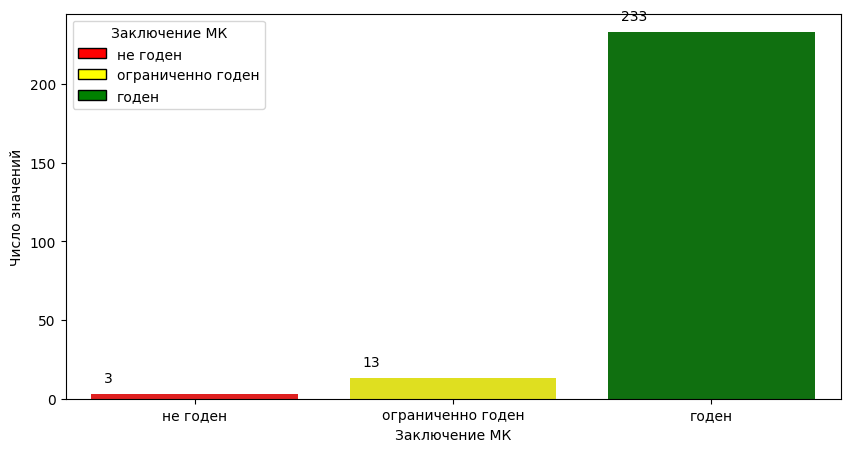

In [27]:
# Визуальная оценка сбалансированности датасета до ресемплинга

from matplotlib.patches import Patch

conclusion_lst = ['не годен', 'ограниченно годен', 'годен']

conclusion_count_arr = np.zeros(3, dtype=int)
# не годен
conclusion_count_arr[0] = len(lst0)
# ограниченно годен
conclusion_count_arr[1] = len(lst1)+len(lst2)+len(lst3)+len(lst4)
# годен
conclusion_count_arr[2] = len(lst5)

print(f'0: не годен: {conclusion_count_arr[0]}')
print(f'1: ограниченно годен: {conclusion_count_arr[1]}')
print(f'2: годен: {conclusion_count_arr[2]}')

plt.figure(figsize=(10, 5))
plot0 = sns.barplot(x=conclusion_lst, y=conclusion_count_arr, palette=["red", "yellow", "green"])
plt.xlabel("Заключение МК")
plt.ylabel("Число значений")
legend_elements = [Patch(facecolor='red', edgecolor='black', label='не годен'),
                   Patch(facecolor='yellow', edgecolor='black', label='ограниченно годен'),
                   Patch(facecolor='green', edgecolor='black', label='годен')]
plt.legend(handles=legend_elements, title="Заключение МК")
# выводим значения над столбиками
for p in plot0.patches:
  plot0.annotate(text='{}'.format(int(p.get_height())),xy=(p.get_x() + 0.05, p.get_height() + 7.5))
plt.show()

**2023.06.24. не балансирую датасет в ожидании файлов с подписанными колонками.**

In [28]:
# # создаем копию нужных строк и добавляем их в отдельный df
# adf0 = df1.loc[lst0].copy()
# print(f'размеры датафрейма adf0: {adf0.shape}, len(lst0): {len(lst0)}')

# adf1 = df1.loc[lst1].copy()
# print(f'размеры датафрейма adf1: {adf1.shape}, len(lst1): {len(lst1)}')

# adf2 = df1.loc[lst2].copy()
# print(f'размеры датафрейма adf2: {adf2.shape}, len(lst2): {len(lst2)}')

# adf3 = df1.loc[lst3].copy()
# print(f'размеры датафрейма adf3: {adf3.shape}, len(lst3): {len(lst3)}')

# adf4 = df1.loc[lst4].copy()
# print(f'размеры датафрейма adf4: {adf4.shape}, len(lst4): {len(lst4)}')

In [29]:
# print(f'размеры датафрейма: df1: {df1.shape}')

# # добавляем новый df в исходный df

# # for i in range(2):
# for i in range(1):
#   for j in range(80):
#     df1 = pd.concat([df1, adf0], ignore_index=True)
#   df1 = pd.concat([df1, adf1], ignore_index=True)
#   for j in range(200):
#     df1 = pd.concat([df1, adf2], ignore_index=True)
#   for j in range(100):
#     df1 = pd.concat([df1, adf3], ignore_index=True)
#     df1 = pd.concat([df1, adf4], ignore_index=True)

# print('='*50)
# print(f'размеры датафрейма: df1: {df1.shape}')

In [30]:
# # Смотрим новые значения целевой колонки
# lst0.clear()
# lst1.clear()
# lst2.clear()
# lst3.clear()
# lst4.clear()
# lst5.clear()

# col_lst = df1.iloc[:, col_inx].tolist()
# for i in range(df1.shape[0]):
#   i_elem = col_lst[i]
#   if (i_elem == i_elem):
#     if i_elem:
#       if not (('машинист бульдозера' == i_elem) or ('Газоспасатель' == i_elem) or (' Газоспасатель' == i_elem)):
#         if 'ВременноНегоден' == i_elem:
#           lst0.append(i)
#         elif 'ГоденСКоррекциейЗрения' == i_elem:
#           lst1.append(i)
#         elif 'ГоденБезРаботНаВысотах' == i_elem:
#           lst2.append(i)
#         elif 'НуждаетсяВДообследованииИЛечении' == i_elem:
#           lst3.append(i)
#         elif 'ОграниченноГоден' == i_elem:
#           lst4.append(i)
#         elif 'Годен' == i_elem:
#           lst5.append(i)
#         else:
#           print(f'{i}->{df1.shape[0]}: i_elem: {i_elem} -> НЕИЗВЕСТНЫЙ ИНДЕКС-ТИП')

# print(f'df1 число строк: {df1.shape[0]}')

# print(f'0: ВременноНегоден: {len(lst0)}')
# print(f'1: ГоденСКоррекциейЗрения: {len(lst1)}')
# print(f'2: ГоденБезРаботНаВысотах: {len(lst2)}')
# print(f'3: НуждаетсяВДообследованииИЛечении: {len(lst3)}')
# print(f'4: ОграниченноГоден: {len(lst4)}')
# print(f'5: Годен: {len(lst5)}')

# print('проверочная сумма по отдельным значениям, c учетом nan и запрещенных значений:')
# print(f'  {df1.shape[0]} -> {len(lst0)+len(lst1)+len(lst2)+len(lst3)+len(lst4)+len(lst5)}')
# print(f'  Годен: {len(lst5)}')
# print(f'  Негоден, Ограниченно годен: {len(lst0)+len(lst1)+len(lst2)+len(lst3)+len(lst4)}')

In [31]:
# # Визуальная оценка сбалансированности датасета после ресемплинга

# # не годен
# conclusion_count_arr[0] = len(lst0)
# # ограниченно годен
# conclusion_count_arr[1] = len(lst1)+len(lst2)+len(lst3)+len(lst4)
# # годен
# conclusion_count_arr[2] = len(lst5)

# print(f'0: не годен: {conclusion_count_arr[0]}')
# print(f'1: ограниченно годен: {conclusion_count_arr[1]}')
# print(f'2: годен: {conclusion_count_arr[2]}')

# plt.figure(figsize=(10, 5))
# plot1 = sns.barplot(x=conclusion_lst, y=conclusion_count_arr, palette=["red", "yellow", "green"])
# plt.xlabel("Заключение МК")
# plt.ylabel("Число значений")
# legend_elements = [Patch(facecolor='red', edgecolor='black', label='не годен'),
#                    Patch(facecolor='yellow', edgecolor='black', label='ограниченно годен'),
#                    Patch(facecolor='green', edgecolor='black', label='годен')]
# plt.legend(handles=legend_elements, title="Заключение МК")
# # выводим значения над столбиками
# for p in plot1.patches:
#   plot1.annotate(text='{}'.format(int(p.get_height())),xy=(p.get_x() + 0.05, p.get_height() + 7.5))
# plt.show()

In [32]:
del lst0
del lst1
del lst2
del lst3
del lst4
del lst5

# del adf0
# del adf1
# del adf2
# del adf3
# del adf4

del conclusion_count_arr

# Удаление из датафрейма строк с пустыми и ошибочными целевыми значениями

In [33]:
#2023.06.24 использовалось в первом датасете

# # Целевая колонка 'ЗаключениеМК'
# nan_lst = df1[df1['ЗаключениеМК'].isnull()].index
# print(f'"ЗаключениеМК": число строк с пустыми значениями: {len(nan_lst)}')
# u_lst = df1['ЗаключениеМК'].unique().tolist()
# print(f'{len(u_lst)}: {u_lst}')

In [34]:
# # Удаляем строки с пустыми и запрещенными значениями в целевой колонке 'ЗаключениеМК'
# # nan, 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель'
# df1 = df1.drop(df1[(df1['ЗаключениеМК'].isnull()) | (df1['ЗаключениеМК'] == 'машинист бульдозера') | (df1['ЗаключениеМК'] == 'Газоспасатель') | (df1['ЗаключениеМК'] == ' Газоспасатель') ].index)
# print(f'размеры датафрейма после удаления строк: {df1.shape}')
# u_lst = df1['ЗаключениеМК'].unique().tolist()
# print(f'{len(u_lst)}: {u_lst}')

# Создаем второй датафрейм для обучения нейросети

In [35]:
# Заполняем колонку ЗаключениеМКК категориальными признаками
# по данным колонки ЗаключениеМК
# 0 - не годен, 1 - ограниченно годен, 2 - годен
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'ЗаключениеМК'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getConclusionCategory(arg):
  '''
    Получение целевого категориального значения по текстовому описанию
    вход:
        arg: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден']
    выход:
        0 - не годен, 1 - ограниченно годен, 2 - годен
  '''
  if ('ГоденСКоррекциейЗрения' == arg) or ('ГоденБезРаботНаВысотах' == arg) or ('ОграниченноГоден' == arg):
    retVal = 1
  elif ('НуждаетсяВДообследованииИЛечении' == arg) or ('ВременноНегоден' == arg):
    retVal = 0
  else:
    retVal = 2

  return retVal

In [36]:
# Получаем список значений колонки
col_inx = df1.columns.get_loc('ЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()

# создаем numpy массив integer из нулей, число элементов равно числу строк нашего data frame
i_arr = np.zeros(df1.shape[0], dtype=int)

# Заполняем массив категориальными индексами
for i in range(df1.shape[0]):
  i_arr[i] = getConclusionCategory(col_lst[i])

# Преобразование массива в формат one_hot_encoding (3-класса)
i_arr2 = utils.to_categorical(i_arr, 3)
ohe_lst2 = i_arr2.astype(int).tolist()
# добавляем новую колонку 'ЗаключениеМКК' в DataFrame 'df1' из массива 'ohe_lst2'
df1 = df1.assign(ЗаключениеМКК=ohe_lst2)

# создаем новый датафрейм, в который будем заносить колонки для обучения нейросети
# и копируем колонку 'ЗаключениеМКК' в новый дата фрэйм
df2 = df1[['ЗаключениеМКК']].copy()
print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (249, 191), df2: (249, 1)


,ЗаключениеМКК
0,"[0, 0, 1]"
1,"[0, 0, 1]"
2,"[0, 0, 1]"


# Категориальные признаки

## Возраст

In [37]:
# КлиентДатаРождения
nan_lst = df1[df1['КлиентДатаРождения'].isnull()].index
print(f'"КлиентДатаРождения": число строк с пустыми значениями: {len(nan_lst)}')
# ДатаЗавершенияМедосмотра
nan_lst = df1[df1['ДатаЗавершенияМедосмотра'].isnull()].index
print(f'"ДатаЗавершенияМедосмотра": число строк с пустыми значениями: {len(nan_lst)}')

"КлиентДатаРождения": число строк с пустыми значениями: 0
"ДатаЗавершенияМедосмотра": число строк с пустыми значениями: 0


In [38]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода Возраст клиента
#~~~~~~~~~~~~~~~~~~~~~~~~
# Возраст клиента = ДатаЗавершенияМедосмотра - КлиентДатаРождения
#~~~~~~~~~~~~~~~~~~~~~~~~
def getAgeCategory(ageN, ageClassCount):
  '''
    Возраст превращаем в категориальный: до 18лет, далее через 5, всего 11 классов
    вход:
        ageN: возраст в годах
        ageClassCount: число классов
    выход:
        retVal: индекс категории: 0-17: 0, 18-22: 1, 23-27: 2, ...., 73..: 10
  '''
  #age2 = int((arg-13)/5)
  age2 = (ageN-13)/5
  retVal = max(0, min((ageClassCount-1),age2))
  return retVal

In [39]:
age_class_count = 11

# КлиентДатаРождения
col_inx = df1.columns.get_loc('КлиентДатаРождения')
col_lst = df1.iloc[:, col_inx].tolist()
datetime_lst1 = []
for time_stamp in col_lst:
  # 2023.06.24 тип колонки изменен
  # datetime_obj = time_stamp.to_pydatetime()
  # datetime_lst1.append(datetime_obj)
  #~~~
  # print(f'time_stamp: {time_stamp}')
  # time_stamp: 1979-07-16T00:00:00
  datetime_obj = datetime.strptime(time_stamp, '%Y-%m-%dT%H:%M:%S')
  datetime_lst1.append(datetime_obj)

# ДатаЗавершенияМедосмотра
col_inx = df1.columns.get_loc('ДатаЗавершенияМедосмотра')
col_lst = df1.iloc[:, col_inx].tolist()
datetime_lst2 = []
for time_stamp in col_lst:
  # # 2023.06.24 тип колонки изменен
  # datetime_obj = time_stamp.to_pydatetime()
  # datetime_lst2.append(datetime_obj)
  #~~~
  # print(f'time_stamp: {time_stamp}')
  # time_stamp: 2023-05-31T00:00:00
  datetime_obj = datetime.strptime(time_stamp, '%Y-%m-%dT%H:%M:%S')
  datetime_lst2.append(datetime_obj)

# рассчитываю возраст клиента
for i in range(df1.shape[0]):
  delta_dates21 = datetime_lst2[i].date() - datetime_lst1[i].date()
  delta_days21 = delta_dates21.days
  delta_years21 = delta_days21 // 365
  i_arr[i] = getAgeCategory(delta_years21, age_class_count)

# Преобразование массива в формат one_hot_encoding
i_arr2 = utils.to_categorical(i_arr, age_class_count)
ohe_lst2 = i_arr2.astype(int).tolist()

# добавляем новую колонку 'Возраст' в 'df2'
df2 = df2.assign(Возраст=ohe_lst2)

# удаление переменных, освобождение памяти
del datetime_lst1
del datetime_lst2

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (249, 191), df2: (249, 2)


,ЗаключениеМКК,Возраст
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
2,"[0, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"


## КлиентПол

In [40]:
nan_lst = df1[df1['КлиентПол'].isnull()].index
print(f'"КлиентПол": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['КлиентПол'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"КлиентПол": число строк с пустыми значениями: 0
2: ['Мужской', 'Женский']


In [41]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение категориального кода 'КлиентПол'
#~~~~~~~~~~~~~~~~~~~~~~~~
def getGenderCategory(arg):
  '''
    Бинарный пол клиента
    вход:
        arg: ['Женский', 'Мужской']
    выход:
        retVal: 0 - Женский, 1 - Мужской
  '''
  if 'Женский' == arg:
    retVal = 0
  else:
    retVal = 1
  return retVal

In [42]:
col_inx = df1.columns.get_loc('КлиентПол')
col_lst = df1.iloc[:, col_inx].tolist()

for i in range(df1.shape[0]):
  i_arr[i] = getGenderCategory(col_lst[i])

# Преобразование массива в формат one_hot_encoding не провожу, так как бинарный тип
# добавляем новую колонку 'КлиентПол' в 'df2'
df2 = df2.assign(КлиентПол=i_arr)

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (249, 191), df2: (249, 3)


,ЗаключениеМКК,Возраст,КлиентПол
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
2,"[0, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1


## ТипМедосмотра

2023.05.08 - 'Периодический', 'Предварительный'

2023.06.26 - 'Периодический'

In [43]:
nan_lst = df1[df1['ТипМедосмотра'].isnull()].index
print(f'"ТипМедосмотра": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ТипМедосмотра'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"ТипМедосмотра": число строк с пустыми значениями: 0
1: ['Периодический']


In [44]:
# #~~~~~~~~~~~~~~~~~~~~~~~~
# # Получение категориального кода 'ТипМедосмотра'
# #~~~~~~~~~~~~~~~~~~~~~~~~
# def getTypeMedExaminationCategory(arg):
#   '''
#     Бинарный Тип Медосмотра
#     вход:
#         arg: ['Периодический', 'Предварительный']
#     выход:
#         retVal: 0 - Периодический, 1 - Предварительный
#   '''
#   if 'Периодический' == arg:
#     retVal = 0
#   else:
#     retVal = 1
#   return retVal

In [45]:
# col_inx = df1.columns.get_loc('ТипМедосмотра')
# col_lst = df1.iloc[:, col_inx].tolist()

# for i in range(df1.shape[0]):
#   i_arr[i] = getTypeMedExaminationCategory(col_lst[i])

# # Преобразование массива в формат one_hot_encoding не провожу, так как бинарный тип
# # добавляем новую колонку 'ТипМедосмотра' в 'df2'
# df2 = df2.assign(ТипМедосмотра=i_arr)

# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)

## ПсихОсвидетельствование

2023.05.08 - False, True

2023.06.26 - False

In [46]:
nan_lst = df1[df1['ПсихОсвидетельствование'].isnull()].index
print(f'"ПсихОсвидетельствование": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['ПсихОсвидетельствование'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

"ПсихОсвидетельствование": число строк с пустыми значениями: 0
1: [False]


In [47]:
# #~~~~~~~~~~~~~~~~~~~~~~~~
# # Получение категориального кода 'ПсихОсвидетельствование'
# #~~~~~~~~~~~~~~~~~~~~~~~~
# def getPsychicExaminationCategory(arg):
#   '''
#     Бинарный Тип ПсихОсвидетельствование
#     вход:
#         arg: [False, True]
#     выход:
#         retVal: 0 - False, 1 - True
#   '''
#   if False == arg:
#     retVal = 0
#   else:
#     retVal = 1
#   return retVal

In [48]:
# col_inx = df1.columns.get_loc('ПсихОсвидетельствование')
# col_lst = df1.iloc[:, col_inx].tolist()

# for i in range(df1.shape[0]):
#   i_arr[i] = getPsychicExaminationCategory(col_lst[i])

# # Преобразование массива в формат one_hot_encoding не провожу, так как бинарный тип
# # добавляем новую колонку 'ПсихОсвидетельствование' в 'df2'
# df2 = df2.assign(ПсихОсвидетельствование=i_arr)

# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)

## ДиспансернаяГруппа

2023.05.08 - ДиспансернаяГруппа

2023.06.26 - нет такого поля

In [49]:
# nan_lst = df1[df1['ДиспансернаяГруппа'].isnull()].index
# print(f'"ДиспансернаяГруппа": число строк с пустыми значениями: {len(nan_lst)}')
# u_lst = df1['ДиспансернаяГруппа'].unique().tolist()
# print(f'{len(u_lst)}: {u_lst}')

In [50]:
# #~~~~~~~~~~~~~~~~~~~~~~~~
# # Получение категориального кода 'ДиспансернаяГруппа'
# #~~~~~~~~~~~~~~~~~~~~~~~~
# def getDispensaryGroupCategory(arg):
#   '''
#     Категориальный Тип ДиспансернаяГруппа
#     вход:
#         один из элементов массива уникальных значений: ['I', 'IIIа', 'II', 'IIIб']
#     выход:
#         retVal: индекс элемента в массиве уникальных значений:
#           0 - nan, 1 - 'I', 2 - 'IIIа', 3 - 'II', 4 - 'IIIб'
#   '''
#   if 'I' == arg:
#     retVal = 1
#   elif 'IIIа' == arg:
#     retVal = 2
#   elif 'II' == arg:
#     retVal = 3
#   elif 'IIIб' == arg:
#     retVal = 4
#   else:
#     retVal = 0

#   return retVal

In [51]:
# dispensary_class_count = 5

# col_inx = df1.columns.get_loc('ДиспансернаяГруппа')
# col_lst = df1.iloc[:, col_inx].tolist()

# # Заполняем массив категориальными индексами
# for i in range(df1.shape[0]):
#   i_arr[i] = getDispensaryGroupCategory(col_lst[i])

# # Преобразование массива в формат one_hot_encoding (5-классов)
# i_arr2 = utils.to_categorical(i_arr, dispensary_class_count)
# ohe_lst2 = i_arr2.astype(int).tolist()

# # добавляем новую колонку 'ДиспансернаяГруппа' в 'df2'
# df2 = df2.assign(ДиспансернаяГруппа=ohe_lst2)

# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)

In [52]:
# df2.tail(2)

## ВредныеФакторы

In [53]:
an_lst = df1[df1['ВредныеФакторы'].isnull()].index
print(f'"ВредныеФакторы": число строк с пустыми значениями: {len(nan_lst)}')

"ВредныеФакторы": число строк с пустыми значениями: 0


In [54]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Расщепление строки по запятым
#~~~~~~~~~~~~~~~~~~~~~~~~
def comma_string_split(arg):
  '''
    Расщепление строки по запятым, удаление пробелов перед словом и после
    вход:
        arg: строка с запятыми или без запятых
    выход:
        retVal: список строк
  '''
  # результирующий список
  retVal = list()
  # проверяем на nan
  if (arg == arg):
    # проверяем, что строка не пустая
    if arg:
      # приводим к нижнему регистру, удаляем пробелы в начале и конце слова
      #str1 = arg.lower().strip()
      str1 = arg.strip()
      # разбиваем строку по запятым и возвращаем список
      str_lst1 = str1.split(',')
      for str_item1 in str_lst1:
        str_item2 = str_item1.strip()
        # проверяем, что строка не пустая
        if str_item2:
          retVal.append(str_item2)

  return retVal

In [55]:
# Формируем список уникальных значений вредных факторов
# Harmful Factors
u_hf_lst = list()

col_inx = df1.columns.get_loc('ВредныеФакторы')
col_lst = df1.iloc[:, col_inx].tolist()
#print(f'df1 число строк: {df1.shape[0]}, len(col_lst): {len(col_lst)}, {col_lst}')

for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  #print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}')
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #print(f'{i}=>{df1.shape[0]}: i_elem: {i_elem}')
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      #print(f'  {len(elem_lst)}: {elem_lst}')
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          #print(f'    elem1_lst: {elem1_lst}')
          if len(u_hf_lst) > 0:
            # проверяем, что этого элемента нет в списке
            flag_lst = elem1_lst in u_hf_lst
            if not flag_lst:
              u_hf_lst.append(elem1_lst)
          else:
            u_hf_lst.append(elem1_lst)

#print(f'{len(u_hf_lst)}: u_hf_lst: {u_hf_lst}')

In [56]:
# создаем словарь ВредныеФакторы: ключи - названия вредных факторов, значения - число повторений
u_hf_dict = {}
for i_elem in u_hf_lst:
  u_hf_dict[i_elem] = 0

# print(f'{len(u_hf_dict)}: u_hf_lst: {u_hf_dict}')

# пробегаемся по всем строкам колонки и заполняем словарь
for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          u_hf_dict[elem1_lst] += 1

# print(f'{len(u_hf_dict)}: u_hf_lst: {u_hf_dict}')

# сортируем словарь по убыванию
u_hf_sort_dict = dict(sorted(u_hf_dict.items(), key=lambda x: x[1], reverse=True))

# print(f'{len(u_hf_sort_dict)}: u_hf_sort_dict: {u_hf_sort_dict}')

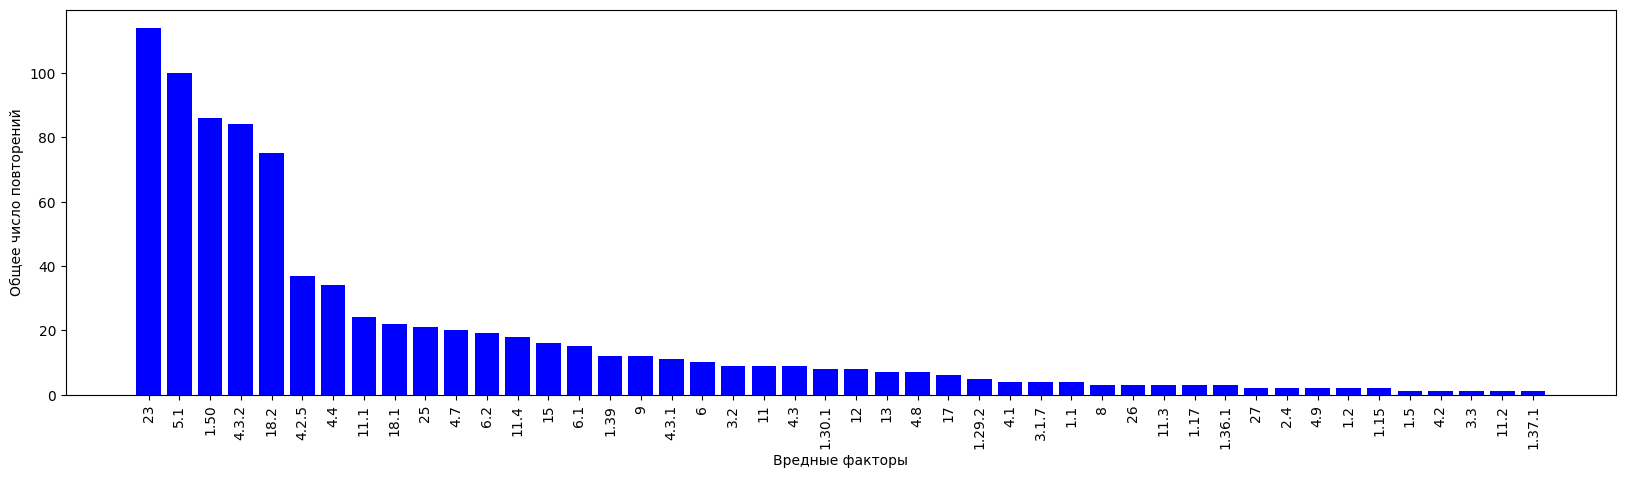

In [57]:
# Отобразим на столбчатую диаграмму - чачтоту использования наших признаков
plt.figure(figsize=(20, 5))
plt.bar(u_hf_sort_dict.keys(), u_hf_sort_dict.values(), color='blue')
plt.xticks(rotation=90)
plt.xlabel('Вредные факторы')
plt.ylabel('Общее число повторений')
plt.gca().set_facecolor('white')
plt.show()

In [58]:
# Формируем список уникальных значений вредных факторов
# из наиболее часто встречающихся -> оставим первые 15
u_hf_lst = list(u_hf_sort_dict.keys())[:15]
del u_hf_dict
del u_hf_sort_dict

print(f'{len(u_hf_lst)}: u_hf_lst: {u_hf_lst}')

15: u_hf_lst: ['23', '5.1', '1.50', '4.3.2', '18.2', '4.2.5', '4.4', '11.1', '18.1', '25', '4.7', '6.2', '11.4', '15', '6.1']


In [59]:
#~~~~~~~~~~~~~~~~~~~~~~~~
#multi_hot_encoding
hf_mhe_lst = list()

# число классов
harmful_factors_class_count = len(u_hf_lst) + 1
# то есть по умолчанию выбираем индекс вредного фактора, которого нет в списке
# наших выбранных и ограниченных уникальных вредных факторов
nan_inx = len(u_hf_lst)

# print(f'{len(col_lst)}: col_lst: {col_lst}')
# print(f'{len(u_hf_lst)}: u_hf_lst: {u_hf_lst}')
# print(f'harmful_factors_class_count: {harmful_factors_class_count}')
# print(f'nan_inx: {nan_inx}')

# пробегаемся по всем строкам колонки
for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}')
  # устанавливаем все признаки в нули
  i_mhe_lst = [0] * harmful_factors_class_count
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      #расщепляем по запятым
      elem_lst = comma_string_split(i_elem)
      if len(elem_lst) > 0:
        for elem1_lst in elem_lst:
          # проверяем, есть ли этот элемент в списке
          if elem1_lst in u_hf_lst:
            inx = u_hf_lst.index(elem1_lst)
            i_mhe_lst[inx] = 1
          else:
            i_mhe_lst[nan_inx] = 1
      else:
        i_mhe_lst[nan_inx] = 1
    else:
      i_mhe_lst[nan_inx] = 1
  else:
    i_mhe_lst[nan_inx] = 1

  # print(f'  {len(i_mhe_lst)}: {i_mhe_lst}')
  hf_mhe_lst.append(i_mhe_lst)

# print(f'{len(hf_mhe_lst)}: hf_mhe_lst: {hf_mhe_lst}')

# добавляем новую колонку 'ВредныеФакторы' в 'df2'
df2 = df2.assign(ВредныеФакторы=hf_mhe_lst)

del hf_mhe_lst

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (249, 191), df2: (249, 4)


,ЗаключениеМКК,Возраст,КлиентПол,ВредныеФакторы
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,"[0, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


## МКБ

In [60]:
def getColNamesByFragmentName(str):
  '''
    Возвращает список названий колонок, в которых содержится заданная строка
    вход:
        str - часть названия колонки, например мкб
    выход:
        retVal - список названий колонок, содержащих заданную строку
  '''
  totalCols = list(df1.columns)
  retVal = [col for col in totalCols if str in col]
  return retVal

In [61]:
# Находим все колонки, в которых присутсвует часть названия '_МКБ'
fragment_str = '_МКБ'
mkb_cols = getColNamesByFragmentName(fragment_str)
print(f'Число колонок, содержащих "{fragment_str}": {len(mkb_cols)}')
print(f'mkb_cols: {mkb_cols}')

Число колонок, содержащих "_МКБ": 35
mkb_cols: ['Стоматология1_МКБ101', 'ПроцедурнаяМедсестра1_МКБ101', 'ПсихиатрияНаркология1_МКБ101', 'Неврология1_МКБ101', 'Хирургия1_МКБ101', 'Гинекология1_МКБ101', 'Оториноларингология1_МКБ101', 'Терапия1_МКБ101', 'УЗИДиагностика1_МКБ101', 'Дерматовенерология1_МКБ101', 'Офтальмология1_МКБ101', 'ФункциональнаяДиагностика1_МКБ101', 'Рентгенология1_МКБ101', 'Терапия2_МКБ101', 'Терапия1_МКБ102', 'Офтальмология1_МКБ102', 'ПсихиатрияНаркология2_МКБ101', 'Дерматовенерология2_МКБ101', 'Неврология1_МКБ102', 'Неврология1_МКБ103', 'Неврология2_МКБ101', 'Терапия1_МКБ103', 'Стоматология2_МКБ101', 'Стоматология1_МКБ102', 'Стоматология1_МКБ103', 'Гинекология2_МКБ101', 'Офтальмология2_МКБ101', 'ЛабораторнаяДиагностика1_МКБ101', 'ЛабораторнаяДиагностика2_МКБ101', 'ПроцедурнаяМедсестра2_МКБ101', 'Терапия3_МКБ101', 'УЗИДиагностика2_МКБ101', 'Психиатрия1_МКБ101', 'Стоматология3_МКБ101', 'Хирургия2_МКБ101']


In [62]:
# Формируем список уникальных значений мкб
# MKB Factors
u_mkb_lst = list()

for mkb_col in mkb_cols:
  col_inx = df1.columns.get_loc(mkb_col)
  col_lst = df1.iloc[:, col_inx].tolist()
  # print(f'df1 число строк: {df1.shape[0]}, mkb_col: {mkb_col}')
  # print(f'  len(col_lst): {len(col_lst)}, {col_lst}')
  # Пробегаем по всем строкам текущей колонки
  for i in range(df1.shape[0]):
    i_elem = col_lst[i]
    # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}')
    # проверяем на nan
    if (i_elem == i_elem):
      # проверяем, что строка не пустая
      if i_elem:
        #print(f'{i}=>{df1.shape[0]}: i_elem: {i_elem}')
        #расщепляем по запятым
        elem_lst = comma_string_split(i_elem)
        #print(f'  {len(elem_lst)}: {elem_lst}')
        if len(elem_lst) > 0:
          for elem1_lst in elem_lst:
            #print(f'    elem1_lst: {elem1_lst}')
            if len(u_mkb_lst) > 0:
              # проверяем, что этого элемента нет в списке
              flag_lst = elem1_lst in u_mkb_lst
              if not flag_lst:
                u_mkb_lst.append(elem1_lst)
            else:
              u_mkb_lst.append(elem1_lst)

# print(f'{len(u_mkb_lst)}: u_mkb_lst: {u_mkb_lst}')

In [63]:
# создаем словарь МКБ: ключи - МКБ, значения - число повторений
u_mkb_dict = {}
for i_elem in u_mkb_lst:
  u_mkb_dict[i_elem] = 0

# print(f'{len(u_mkb_dict)}: u_mkb_lst: {u_mkb_dict}')

# пробегаемся по всем строкам колонок и заполняем словарь
for mkb_col in mkb_cols:
  col_inx = df1.columns.get_loc(mkb_col)
  col_lst = df1.iloc[:, col_inx].tolist()
  for i in range(df1.shape[0]):
    i_elem = col_lst[i]
    # проверяем на nan
    if (i_elem == i_elem):
      # проверяем, что строка не пустая
      if i_elem:
        #расщепляем по запятым
        elem_lst = comma_string_split(i_elem)
        if len(elem_lst) > 0:
          for elem1_lst in elem_lst:
            u_mkb_dict[elem1_lst] += 1

# print(f'{len(u_mkb_dict)}: u_mkb_lst: {u_mkb_dict}')

# сортируем словарь по убыванию
u_mkb_sort_dict = dict(sorted(u_mkb_dict.items(), key=lambda x: x[1], reverse=True))

# print(f'{len(u_mkb_sort_dict)}: u_mkb_sort_dict: {u_mkb_sort_dict}')

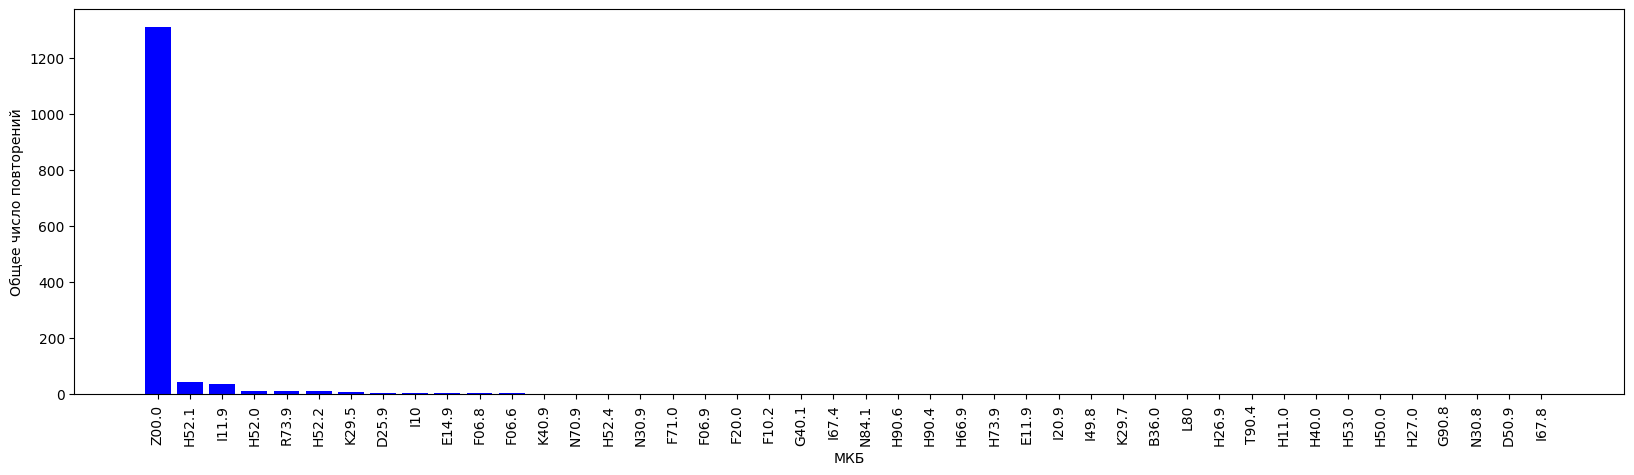

In [64]:
# Отобразим на столбчатую диаграмму - чачтоту использования наших признаков
plt.figure(figsize=(20, 5))
plt.bar(u_mkb_sort_dict.keys(), u_mkb_sort_dict.values(), color='blue')
plt.xticks(rotation=90)
plt.xlabel('МКБ')
plt.ylabel('Общее число повторений')
plt.gca().set_facecolor('white')
plt.show()

In [65]:
# Формируем список уникальных значений МКБ
# из наиболее часто встречающихся -> оставим первые 3
u_mkb_lst = list(u_mkb_sort_dict.keys())[:3]
del u_mkb_dict
del u_mkb_sort_dict

print(f'{len(u_mkb_lst)}: u_mkb_lst: {u_mkb_lst}')

3: u_mkb_lst: ['Z00.0', 'H52.1', 'I11.9']


In [66]:
#~~~~~~~~~~~~~~~~~~~~~~~~
#multi_hot_encoding
mkb_mhe_lst = list()

# число классов
mkb_class_count = len(u_mkb_lst) + 1
# то есть по умолчанию выбираем индекс мкб, которого нет в списке
# наших выбранных и ограниченных мкб факторов
nan_inx = len(u_mkb_lst)

for i in range(df1.shape[0]):
  # устанавливаем все признаки в нули
  i_mhe_lst = [0] * mkb_class_count
  mkb_mhe_lst.append(i_mhe_lst)

# print(f'{len(u_mkb_lst)}: u_mkb_lst: {u_mkb_lst}')
# print(f'mkb_class_count: {mkb_class_count}')
# print(f'nan_inx: {nan_inx}')
# print(f'{len(mkb_mhe_lst)}: mkb_mhe_lst: {mkb_mhe_lst}')

# пробегаемся по всем строкам колонок и заполняем словарь
for mkb_col in mkb_cols:
  col_inx = df1.columns.get_loc(mkb_col)
  col_lst = df1.iloc[:, col_inx].tolist()
  # пробегаемся по всем строкам колонки
  for i in range(df1.shape[0]):
    i_elem = col_lst[i]
    # print(f'mkb_col: {mkb_col}: {i}->{df1.shape[0]}: i_elem: {i_elem}')
    # считываем все признаки
    i_mhe_lst = mkb_mhe_lst[i]
    # проверяем на nan
    if (i_elem == i_elem):
      # проверяем, что строка не пустая
      if i_elem:
        #расщепляем по запятым
        elem_lst = comma_string_split(i_elem)
        if len(elem_lst) > 0:
          for elem1_lst in elem_lst:
            # проверяем, есть ли этот элемент в списке
            if elem1_lst in u_mkb_lst:
              inx = u_mkb_lst.index(elem1_lst)
              i_mhe_lst[inx] = 1
            else:
              i_mhe_lst[nan_inx] = 1
        else:
          i_mhe_lst[nan_inx] = 1
      else:
        i_mhe_lst[nan_inx] = 1
    else:
      i_mhe_lst[nan_inx] = 1

  # print(f'  {len(i_mhe_lst)}: {i_mhe_lst}')
  mkb_mhe_lst[i] = i_mhe_lst

# print(f'{len(mkb_mhe_lst)}: mkb_mhe_lst: {mkb_mhe_lst}')

# добавляем новую колонку 'МКБ' в 'df2'
df2 = df2.assign(МКБ=mkb_mhe_lst)

del mkb_mhe_lst

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (249, 191), df2: (249, 5)


,ЗаключениеМКК,Возраст,КлиентПол,ВредныеФакторы,МКБ
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1]"
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1]"
2,"[0, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1]"


## ГоденНегоден

2023.05.08 - ГоденНегоден

2023.06.26 - нет такого поля

In [67]:
# Создаем гендерный массив, для обработки колонки Гинекология
# 0 - Женский, 1 - Мужской

nan_lst = df1[df1['КлиентПол'].isnull()].index
print(f'"КлиентПол": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['КлиентПол'].unique().tolist()
print(f'{len(u_lst)}: {u_lst}')

col_inx = df1.columns.get_loc('КлиентПол')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'{len(col_lst)}: {col_lst}')

gender_arr = np.zeros(df1.shape[0], dtype=int)
for i in range(df1.shape[0]):
  gender_arr[i] = getGenderCategory(col_lst[i])

# print(f'{len(col_lst)}: {col_lst}')
print(f'gender_arr: {gender_arr.shape}')
# print(f'{len(gender_arr)}: {gender_arr}')

"КлиентПол": число строк с пустыми значениями: 0
2: ['Мужской', 'Женский']
gender_arr: (249,)


In [68]:
# Находим все колонки, в которых присутсвует часть названия '_ГоденНегоден'
# Хирургия1_ГоденНегоден_Значение: 4->4457: i_elem: 072d79e3-1cc0-11e8-80c9-0cc47aab8067
# fuf_col: Гинекология1_ГоденНегоден_ЗначениеПредставление: 16->4457: i_elem: Годен
# fuf_col: Гинекология1_ГоденНегоден_ЗначениеПредставление: 17->4457: i_elem: Не годен
#
# ПОЭТОМУ БУДЕМ ИСПОЛЬЗОВАТЬ КОЛОНКУ `_ГоденНегоден_ЗначениеПредставление`,
# В КОЛОНКЕ `_ГоденНегоден_Значение` ЗАШИФРОВАННЫЕ ЗНАЧЕНИЯ

fragment_str = '_ГоденНегоден_ЗначениеПредставление'
# fit unfit
fuf_cols = getColNamesByFragmentName(fragment_str)
# Сортируем список
fuf_cols.sort()

print(f'Число колонок, содержащих "{fragment_str}": {len(fuf_cols)}')
print('-'*50)
for i in range(len(fuf_cols)):
  print(f'{i}: {fuf_cols[i]}')

Число колонок, содержащих "_ГоденНегоден_ЗначениеПредставление": 0
--------------------------------------------------


In [69]:
# #~~~~~~~~~~~~~~~~~~~~~~~~
# # Объединение врач1,врач2,врач3,врач4 в одну колонку
# # fit unfit
# #~~~~~~~~~~~~~~~~~~~~~~~~
# def fuf1234_merge(col_names_lst):
#   '''
#     Объединение врач1,врач2,врач3,врач4 в одну колонку
#     вход:
#         colNames1234: список названий колонок для объединения
#         df1234: dataframe
#     выход:
#         retVal: массив 0 - не годен, 1 - ограниченно годен, 2 - годен
#   '''
#   retVal = np.ones(df1.shape[0], dtype=int)

#   # print(f'df1 число строк : {df1.shape[0]}')
#   # print(f'df1 число столбцов : {df1.shape[1]}')
#   # print(f'{len(col_names_lst)} : {col_names_lst}')
#   # print(f'retVal: {retVal.shape}')
#   # print(f'{len(retVal)} : {retVal}')

#   for j in range(len(col_names_lst)):
#     # print(f'{j}: {col_names_lst[j]}')
#     col_inx = df1.columns.get_loc(col_names_lst[j])
#     col_lst = df1.iloc[:, col_inx].tolist()
#     # u_ls = df1[col_names_lst[j]].unique().tolist()
#     # print(f'{len(col_lst)}: {u_ls}')
#     # print(f'{len(col_lst)}: {col_lst}')
#     # пробегаемся по всем строкам колонки
#     for i in range(df1.shape[0]):
#       i_elem = col_lst[i]
#       # print(f'{col_names_lst[j]}: {i}->{df1.shape[0]}: i_elem: {i_elem}')
#       # проверяем на nan
#       if (i_elem == i_elem):
#         # проверяем, что строка не пустая
#         if i_elem:
#           ui_elem = i_elem.lower()
#           # print(f'{col_names_lst[j]}: {i}->{df1.shape[0]}: i_elem: {i_elem}, ui_elem: {ui_elem}')
#           # 0 - не годен, 1 - ограниченно годен, 2 - годен
#           if 'не годен' == ui_elem:
#             retVal[i] = 0
#           elif 'годен' == ui_elem:
#             if 1 == retVal[i]:
#               retVal[i] = 2

#   return retVal

In [70]:
# #~~~ 0
# # 0: Гинекология1_ГоденНегоден_ЗначениеПредставление
# # 1: Гинекология2_ГоденНегоден_ЗначениеПредставление
# # 2: Гинекология3_ГоденНегоден_ЗначениеПредставление
# # 3: Гинекология4_ГоденНегоден_ЗначениеПредставление
# fuf_lst = list()
# fuf_lst.append(fuf_cols[0])
# fuf_lst.append(fuf_cols[1])
# fuf_lst.append(fuf_cols[2])
# fuf_lst.append(fuf_cols[3])
# print(f'{len(fuf_lst)}: {fuf_lst}')

# fuf_arr = fuf1234_merge(fuf_lst)

# # print(f'{len(fuf_arr)}: {fuf_arr}')
# # print(f'{gender_arr.shape}: {gender_arr}')

# # пробегаемся по всем строкам колонки
# # исправляем по гендерному признаку: мужчина по определению годен
# for i in range(df1.shape[0]):
#   if 1 == gender_arr[i]:
#     fuf_arr[i] = 2

# # Преобразование массива в формат one_hot_encoding (3-класса)
# i_arr2 = utils.to_categorical(fuf_arr, 3)
# ohe_lst2 = i_arr2.astype(int).tolist()
# # добавляем новую колонку 'ГинекологияГНГ' в 'df2'
# df2 = df2.assign(ГинекологияГНГ=ohe_lst2)
# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)

In [71]:
# #~~~ 1
# # 4: Дерматовенерология1_ГоденНегоден_ЗначениеПредставление
# # 5: Дерматовенерология2_ГоденНегоден_ЗначениеПредставление
# fuf_lst.clear()
# fuf_lst.append(fuf_cols[4])
# fuf_lst.append(fuf_cols[5])
# print(f'{len(fuf_lst)}: {fuf_lst}')

# fuf_arr = fuf1234_merge(fuf_lst)
# # print(f'{len(fuf_arr)}: {fuf_arr}')
# # Преобразование массива в формат one_hot_encoding (3-класса)
# i_arr2 = utils.to_categorical(fuf_arr, 3)
# ohe_lst2 = i_arr2.astype(int).tolist()
# # добавляем новую колонку 'ДерматовенерологияГНГ' в 'df2'
# df2 = df2.assign(ДерматовенерологияГНГ=ohe_lst2)
# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)

In [72]:
# #~~~ 2
# # 6: Неврология1_ГоденНегоден_ЗначениеПредставление
# # 7: Неврология2_ГоденНегоден_ЗначениеПредставление
# fuf_lst.clear()
# fuf_lst.append(fuf_cols[6])
# fuf_lst.append(fuf_cols[7])
# print(f'{len(fuf_lst)}: {fuf_lst}')

# fuf_arr = fuf1234_merge(fuf_lst)
# # print(f'{len(fuf_arr)}: {fuf_arr}')
# # Преобразование массива в формат one_hot_encoding (3-класса)
# i_arr2 = utils.to_categorical(fuf_arr, 3)
# ohe_lst2 = i_arr2.astype(int).tolist()
# # добавляем новую колонку 'НеврологияГНГ' в 'df2'
# df2 = df2.assign(НеврологияГНГ=ohe_lst2)
# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)

In [73]:
# #~~~ 3
# # 8: Оториноларингология1_ГоденНегоден_ЗначениеПредставление
# # 9: Оториноларингология2_ГоденНегоден_ЗначениеПредставление
# # 10: Оториноларингология3_ГоденНегоден_ЗначениеПредставление
# fuf_lst.clear()
# fuf_lst.append(fuf_cols[8])
# fuf_lst.append(fuf_cols[9])
# fuf_lst.append(fuf_cols[10])
# print(f'{len(fuf_lst)}: {fuf_lst}')

# fuf_arr = fuf1234_merge(fuf_lst)
# # print(f'{len(fuf_arr)}: {fuf_arr}')
# # Преобразование массива в формат one_hot_encoding (3-класса)
# i_arr2 = utils.to_categorical(fuf_arr, 3)
# ohe_lst2 = i_arr2.astype(int).tolist()
# # добавляем новую колонку 'ОториноларингологияГНГ' в 'df2'
# df2 = df2.assign(ОториноларингологияГНГ=ohe_lst2)
# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)

In [74]:
# #~~~ 4
# # 11: Офтальмология1_ГоденНегоден_ЗначениеПредставление
# # 12: Офтальмология2_ГоденНегоден_ЗначениеПредставление
# fuf_lst.clear()
# fuf_lst.append(fuf_cols[11])
# fuf_lst.append(fuf_cols[12])
# print(f'{len(fuf_lst)}: {fuf_lst}')

# fuf_arr = fuf1234_merge(fuf_lst)
# # print(f'{len(fuf_arr)}: {fuf_arr}')
# # Преобразование массива в формат one_hot_encoding (3-класса)
# i_arr2 = utils.to_categorical(fuf_arr, 3)
# ohe_lst2 = i_arr2.astype(int).tolist()
# # добавляем новую колонку 'ОфтальмологияГНГ' в 'df2'
# df2 = df2.assign(ОфтальмологияГНГ=ohe_lst2)
# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)

In [75]:
# #~~~ 5
# # 13: Психиатрия1_ГоденНегоден_ЗначениеПредставление
# # 14: Психиатрия2_ГоденНегоден_ЗначениеПредставление
# # 15: Психиатрия3_ГоденНегоден_ЗначениеПредставление
# # 16: Психиатрия4_ГоденНегоден_ЗначениеПредставление
# fuf_lst.clear()
# fuf_lst.append(fuf_cols[13])
# fuf_lst.append(fuf_cols[14])
# fuf_lst.append(fuf_cols[15])
# fuf_lst.append(fuf_cols[16])
# print(f'{len(fuf_lst)}: {fuf_lst}')

# fuf_arr = fuf1234_merge(fuf_lst)
# # print(f'{len(fuf_arr)}: {fuf_arr}')
# # Преобразование массива в формат one_hot_encoding (3-класса)
# i_arr2 = utils.to_categorical(fuf_arr, 3)
# ohe_lst2 = i_arr2.astype(int).tolist()
# # добавляем новую колонку 'ПсихиатрияГНГ' в 'df2'
# df2 = df2.assign(ПсихиатрияГНГ=ohe_lst2)
# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)

In [76]:
# #~~~ 6
# # 17: ПсихиатрияНаркология1_ГоденНегоден_ЗначениеПредставление
# # 18: ПсихиатрияНаркология2_ГоденНегоден_ЗначениеПредставление
# fuf_lst.clear()
# fuf_lst.append(fuf_cols[17])
# fuf_lst.append(fuf_cols[18])
# print(f'{len(fuf_lst)}: {fuf_lst}')

# fuf_arr = fuf1234_merge(fuf_lst)
# # print(f'{len(fuf_arr)}: {fuf_arr}')
# # Преобразование массива в формат one_hot_encoding (3-класса)
# i_arr2 = utils.to_categorical(fuf_arr, 3)
# ohe_lst2 = i_arr2.astype(int).tolist()
# # добавляем новую колонку 'ПсихиатрияНаркологияГНГ' в 'df2'
# df2 = df2.assign(ПсихиатрияНаркологияГНГ=ohe_lst2)
# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)

In [77]:
# #~~~ 7
# # 19: Стоматология1_ГоденНегоден_ЗначениеПредставление
# # 20: Стоматология2_ГоденНегоден_ЗначениеПредставление
# fuf_lst.clear()
# fuf_lst.append(fuf_cols[19])
# fuf_lst.append(fuf_cols[20])
# print(f'{len(fuf_lst)}: {fuf_lst}')

# fuf_arr = fuf1234_merge(fuf_lst)
# # print(f'{len(fuf_arr)}: {fuf_arr}')
# # Преобразование массива в формат one_hot_encoding (3-класса)
# i_arr2 = utils.to_categorical(fuf_arr, 3)
# ohe_lst2 = i_arr2.astype(int).tolist()
# # добавляем новую колонку 'СтоматологияГНГ' в 'df2'
# df2 = df2.assign(СтоматологияГНГ=ohe_lst2)
# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)

In [78]:
# ~~~ 8
# 21: ТерапевтНеИсп1_ГоденНегоден_ЗначениеПредставление
# col_inx = df1.columns.get_loc(fuf_cols[21])
# u_ls = df1[fuf_cols[21]].unique().tolist()
# col_lst = df1.iloc[:, col_inx].tolist()

# print(f'{fuf_cols[21]}:')
# print(f'{len(u_ls)}: {u_ls}')
# print(f'{len(col_lst)}: {col_lst}')

# ТерапевтНеИсп1_ГоденНегоден_ЗначениеПредставление:
# 2: [nan, 'Годен']


# ->ТерапевтНеИсп не использую эту колонку

In [79]:
# #~~~ 9
# # 22: Терапия1_ГоденНегоден_ЗначениеПредставление
# # 23: Терапия2_ГоденНегоден_ЗначениеПредставление
# # 24: Терапия3_ГоденНегоден_ЗначениеПредставление
# # 25: Терапия4_ГоденНегоден_ЗначениеПредставление
# fuf_lst.clear()
# fuf_lst.append(fuf_cols[22])
# fuf_lst.append(fuf_cols[23])
# fuf_lst.append(fuf_cols[24])
# fuf_lst.append(fuf_cols[25])
# print(f'{len(fuf_lst)}: {fuf_lst}')

# fuf_arr = fuf1234_merge(fuf_lst)
# # print(f'{len(fuf_arr)}: {fuf_arr}')
# # Преобразование массива в формат one_hot_encoding (3-класса)
# i_arr2 = utils.to_categorical(fuf_arr, 3)
# ohe_lst2 = i_arr2.astype(int).tolist()
# # добавляем новую колонку 'ТерапияГНГ' в 'df2'
# df2 = df2.assign(ТерапияГНГ=ohe_lst2)
# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)

In [80]:
#~~~ 10
# 26: ХирургНеИсп1_ГоденНегоден_ЗначениеПредставление
# 27: ХирургНеИсп2_ГоденНегоден_ЗначениеПредставление

# ->ХирургНеИсп не использую эту колонку

In [81]:
# #~~~ 11
# # 28: Хирургия1_ГоденНегоден_ЗначениеПредставление
# # 29: Хирургия2_ГоденНегоден_ЗначениеПредставление
# # 30: Хирургия3_ГоденНегоден_ЗначениеПредставление
# fuf_lst.clear()
# fuf_lst.append(fuf_cols[28])
# fuf_lst.append(fuf_cols[29])
# fuf_lst.append(fuf_cols[30])
# print(f'{len(fuf_lst)}: {fuf_lst}')

# fuf_arr = fuf1234_merge(fuf_lst)
# # print(f'{len(fuf_arr)}: {fuf_arr}')
# # Преобразование массива в формат one_hot_encoding (3-класса)
# i_arr2 = utils.to_categorical(fuf_arr, 3)
# ohe_lst2 = i_arr2.astype(int).tolist()
# # добавляем новую колонку 'ХирургияГНГ' в 'df2'
# df2 = df2.assign(ХирургияГНГ=ohe_lst2)
# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)

In [82]:
del fuf_cols
# del fuf_lst
# del fuf_arr

## Диагноз

In [90]:
# Гендерный массив, для обработки колонки Гинекология
# 0 - Женский, 1 - Мужской
print(f'gender_arr: {gender_arr.shape}')
# print(f'{len(gender_arr)}: {gender_arr}')

gender_arr: (249,)


In [91]:
# Находим все колонки, в которых присутсвует часть названия '_Диагноз'
fragment_str = '_Диагноз'
# diagnosis
dgns_cols = getColNamesByFragmentName(fragment_str)
# Сортируем список
dgns_cols.sort()

print(f'Число колонок, содержащих "{fragment_str}": {len(dgns_cols)}')
print('-'*50)
for i in range(len(dgns_cols)):
  print(f'{i}: {dgns_cols[i]}')

Число колонок, содержащих "_Диагноз": 75
--------------------------------------------------
0: Гинекология1_Диагноз_Значение
1: Гинекология1_Диагноз_ЗначениеПредставление
2: Гинекология1_ДиагнозПредставление1
3: Гинекология2_Диагноз_Значение
4: Гинекология2_Диагноз_ЗначениеПредставление
5: Гинекология2_ДиагнозПредставление1
6: Дерматовенерология1_Диагноз_Значение
7: Дерматовенерология1_Диагноз_ЗначениеПредставление
8: Дерматовенерология1_ДиагнозПредставление1
9: Дерматовенерология2_Диагноз_Значение
10: Дерматовенерология2_Диагноз_ЗначениеПредставление
11: Дерматовенерология2_ДиагнозПредставление1
12: ЛабораторнаяДиагностика1_ДиагнозПредставление1
13: ЛабораторнаяДиагностика2_ДиагнозПредставление1
14: Неврология1_Диагноз_Значение
15: Неврология1_Диагноз_ЗначениеПредставление
16: Неврология1_ДиагнозПредставление1
17: Неврология1_ДиагнозПредставление2
18: Неврология1_ДиагнозПредставление3
19: Неврология2_Диагноз_Значение
20: Неврология2_Диагноз_ЗначениеПредставление
21: Неврология2_Диагно

In [93]:
# 0: Гинекология1_Диагноз_Значение
  # 16->3014: i_elem: [N95.2] Постменопаузный атрофический вагинит_x000D_
  # 17->3014: i_elem: [Z00.0] Общий медицинский осмотр_x000D_
  # 23->3014: i_elem: [N95.1]  Менопауза и климактерические состояния у женщины_x000D_
  # 70->3014: i_elem: [D25] Лейомиома матки_x000D_
  # 71->3014: i_elem: [Z00.0] Общий медицинский осмотр_x000D_
  # 82->3014: i_elem: [N95.1]  Менопауза и климактерические состояния у женщины_x000D_
#~~~1: Гинекология1_Диагноз_ЗначениеПредставление
  # 16->3014: i_elem: [N95.2] Постменопаузный атрофический вагинит_x000D_
  # 17->3014: i_elem: [Z00.0] Общий медицинский осмотр_x000D_
  # 23->3014: i_elem: [N95.1]  Менопауза и климактерические состояния у женщины_x000D_
# 2: Гинекология1_ДиагнозДополнение_Значение
  # 16->3014: i_elem: 1. узи омт 2. обследование и лечение гинеколога
  # 23->3014: i_elem: 1.узи омт 2. обследование и лечение гинеколога
# 3: Гинекология1_ДиагнозДополнение_ЗначениеПредставление
  # 16->3014: i_elem: 1. узи омт 2. обследование и лечение гинеколога
  # 23->3014: i_elem: 1.узи омт 2. обследование и лечение гинеколога
# 4: Гинекология1_ДиагнозПредставление1
  # 17->3014: i_elem: Общий медицинский осмотр
  # 24->3014: i_elem: Общий медицинский осмотр
# 5: Гинекология1_ДиагнозПредставление2
  # 66->3014: i_elem: Миопия
  # 389->3014: i_elem: Общий медицинский осмотр

#~~~~~~~~~~~~~~~~~~~~~~~~
# 136: УЗИДиагностика1_ДиагнозПредставление1
  # 21->3014: i_elem: Общий медицинский осмотр
  # 22->3014: i_elem: Общий медицинский осмотр
  # 33->3014: i_elem: Фиброаденоз молочной железы
# 137: УЗИДиагностика1_ДиагнозПредставление2
  # 172->3014: i_elem: Киста почки
  # 375->3014: i_elem: Общий медицинский осмотр
  # 376->3014: i_elem: Общий медицинский осмотр
# 138: УЗИДиагностика1_ДиагнозПредставление3
  # 389->3014: i_elem: Камни желчного пузыря без холецистита
  # 398->3014: i_elem: Камни желчного пузыря без холецистита
# 139: УЗИДиагностика1_ДиагнозПредставление4
  # 389->3014: i_elem: Камни желчного пузыря без холецистита
  # 398->3014: i_elem: Камни желчного пузыря без холецистита
# 140: УЗИДиагностика2_ДиагнозПредставление1
  # 22->3014: i_elem: Общий медицинский осмотр
  # 375->3014: i_elem: Общий медицинский осмотр
# 141: УЗИДиагностика2_ДиагнозПредставление2
  # 375->3014: i_elem: Общий медицинский осмотр
  # 376->3014: i_elem: Общий медицинский осмотр
# 142: УЗИДиагностика2_ДиагнозПредставление3
  # 389->3014: i_elem: Камни желчного пузыря без холецистита
  # 398->3014: i_elem: Камни желчного пузыря без холецистита
# 143: УЗИДиагностика2_ДиагнозПредставление4
  # 389->3014: i_elem: Камни желчного пузыря без холецистита
  # 398->3014: i_elem: Камни желчного пузыря без холецистита
# 144: ФункциональнаяДиагностика1_ДиагнозПредставление1
  # 141->3014: i_elem: Общий медицинский осмотр
  # 145->3014: i_elem: Общий медицинский осмотр

#~~~~~~~~~~~~~~~~~~~~~~~~
# 153: Хирургия1_Диагноз_Значение
  # 26->3014: i_elem: [Z00.0] Общий медицинский осмотр_x000D_
  # 27->3014: i_elem: [S68.2] Травматическая ампутация двух и более пальцев кисти (полная) (частичная)_x000D_
#~~~154: Хирургия1_Диагноз_ЗначениеПредставление
  # 26->3014: i_elem: [Z00.0] Общий медицинский осмотр_x000D_
  # 27->3014: i_elem: [S68.2] Травматическая ампутация двух и более пальцев кисти (полная) (частичная)_x000D_
# 155: Хирургия1_ДиагнозДополнение_Значение
  # 1378->3014: i_elem: расширение вен по поверхности голени.
# 156: Хирургия1_ДиагнозДополнение_ЗначениеПредставление
  # 1378->3014: i_elem: расширение вен по поверхности голени.
# 157: Хирургия1_ДиагнозПредставление1
  # 4->3014: i_elem: Общий медицинский осмотр
  # 5->3014: i_elem: Общий медицинский осмотр
# 158: Хирургия1_ДиагнозПредставление2
  # 375->3014: i_elem: Односторонняя или неуточненная паховая грыжа без непроходимости или гангрены
  # 378->3014: i_elem: Общий медицинский осмотр

#~~~~~~~~~~~~~~~~~~~~~~~~
# 159: Хирургия2_Диагноз_Значение
  # 89->3014: i_elem: [Z00.0] Общий медицинский осмотр_x000D_
  # 375->3014: i_elem: [K40.9] Односторонняя или неуточненная паховая грыжа без непроходимости или гангрены_x000D_
#~~~160: Хирургия2_Диагноз_ЗначениеПредставление
  # 89->3014: i_elem: [Z00.0] Общий медицинский осмотр_x000D_
  # 375->3014: i_elem: [K40.9] Односторонняя или неуточненная паховая грыжа без непроходимости или гангрены_x000D_
# 161: Хирургия2_ДиагнозДополнение_Значение
# 162: Хирургия2_ДиагнозДополнение_ЗначениеПредставление
# 163: Хирургия2_ДиагнозПредставление1
# 164: Хирургия2_ДиагнозПредставление2
# 165: Хирургия3_Диагноз_Значение
# 166: Хирургия3_Диагноз_ЗначениеПредставление
# 167: Хирургия3_ДиагнозПредставление1

#~~~~~~~~~~~~~~~~~~~~~~~~
# 116: Терапия1_Диагноз_Значение
  # 523->3014: i_elem: [Z00.0] Общий медицинский осмотр_x000D_
  # 586->3014: i_elem: [K29.3] Хронический поверхностный гастрит_x000D_
  # 601->3014: i_elem: [K29.8] Дуоденит_x000D_
  # 613->3014: i_elem: [I11.9] Гипертензивная [гипертоническая] болезнь с преимущественным поражением сердца без (застойной) сердечной недостаточности_x000D_
#~~~117: Терапия1_Диагноз_ЗначениеПредставление
  # 523->3014: i_elem: [Z00.0] Общий медицинский осмотр_x000D_
  # 586->3014: i_elem: [K29.3] Хронический поверхностный гастрит_x000D_
  # 601->3014: i_elem: [K29.8] Дуоденит_x000D_
  # 613->3014: i_elem: [I11.9] Гипертензивная [гипертоническая] болезнь с преимущественным поражением сердца без (застойной) сердечной недостаточности_x000D_
# 118: Терапия1_ДиагнозПредставление1
# 119: Терапия1_ДиагнозПредставление2
# 120: Терапия1_ДиагнозПредставление3
# 121: Терапия1_ДиагнозПредставление4

#~~~~~~~~~~~~~~~~~~~~~~~~
# 122: Терапия2_Диагноз_Значение
#~~~123: Терапия2_Диагноз_ЗначениеПредставление
  # 367->3014: i_elem: [Z00.0] Общий медицинский осмотр_x000D_
  # 489->3014: i_elem: [K29.3] Хронический поверхностный гастрит_x000D_
  # 527->3014: i_elem: [I11.9] Гипертензивная [гипертоническая] болезнь с преимущественным поражением сердца без (застойной) сердечной недостаточности_x000D_
# 124: Терапия2_ДиагнозПредставление1
# 125: Терапия2_ДиагнозПредставление2
# 126: Терапия2_ДиагнозПредставление3
# 127: Терапия2_ДиагнозПредставление4

#~~~~~~~~~~~~~~~~~~~~~~~~
# 128: Терапия3_Диагноз_Значение
#~~~129: Терапия3_Диагноз_ЗначениеПредставление
  # 388->3014: i_elem: [I11.9] Гипертензивная [гипертоническая] болезнь с преимущественным поражением сердца без (застойной) сердечной недостаточности_x000D_
  # 396->3014: i_elem: [I11.9] Гипертензивная [гипертоническая] болезнь с преимущественным поражением сердца без (застойной) сердечной недостаточности_x000D_
  # 425->3014: i_elem: [Z00.0] Общий медицинский осмотр_x000D_
# 130: Терапия3_ДиагнозПредставление1
# 131: Терапия3_ДиагнозПредставление2

#~~~~~~~~~~~~~~~~~~~~~~~~
# 132: Терапия4_Диагноз_Значение
#~~~133: Терапия4_Диагноз_ЗначениеПредставление
  # 388->3014: i_elem: [I11.9] Гипертензивная [гипертоническая] болезнь с преимущественным поражением сердца без (застойной) сердечной недостаточности_x000D_
  # 396->3014: i_elem: [I11.9] Гипертензивная [гипертоническая] болезнь с преимущественным поражением сердца без (застойной) сердечной недостаточности_x000D_
  # 425->3014: i_elem: [Z00.0] Общий медицинский осмотр_x000D_
# 134: Терапия4_ДиагнозПредставление1
# 135: Терапия4_ДиагнозПредставление2

#~~~~~~~~~~~~~~~~~~~~~~~~
# dgns_col = 'Терапия4_Диагноз_ЗначениеПредставление'
# col_inx = df1.columns.get_loc(dgns_col)
# col_lst = df1.iloc[:, col_inx].tolist()
# print(f'df1 число строк: {df1.shape[0]}, dgns_col: {dgns_col}')
# # print(f'  len(col_lst): {len(col_lst)}, {col_lst}')
# print('~'*50)
# # Пробегаем по всем строкам текущей колонки
# for i in range(df1.shape[0]):
#   i_elem = col_lst[i]
#   # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}')
#   # проверяем на nan
#   if (i_elem == i_elem):
#     # проверяем, что строка не пустая
#     if i_elem:
#       print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}')

Выбираю колонки с кодом болезни от каждого профильного специалиста, то есть колонки, которые содержат '_Диагноз_ЗначениеПредставление'

In [94]:
# Находим все колонки, в которых присутсвует часть названия '_Диагноз'
fragment_str = '_Диагноз_ЗначениеПредставление'
# diagnosis
dgns_cols = getColNamesByFragmentName(fragment_str)
# Сортируем список
dgns_cols.sort()

print(f'Число колонок, содержащих "{fragment_str}": {len(dgns_cols)}')
print('-'*50)
for i in range(len(dgns_cols)):
  print(f'{i}: {dgns_cols[i]}')

Число колонок, содержащих "_Диагноз_ЗначениеПредставление": 20
--------------------------------------------------
0: Гинекология1_Диагноз_ЗначениеПредставление
1: Гинекология2_Диагноз_ЗначениеПредставление
2: Дерматовенерология1_Диагноз_ЗначениеПредставление
3: Дерматовенерология2_Диагноз_ЗначениеПредставление
4: Неврология1_Диагноз_ЗначениеПредставление
5: Неврология2_Диагноз_ЗначениеПредставление
6: Оториноларингология1_Диагноз_ЗначениеПредставление
7: Офтальмология1_Диагноз_ЗначениеПредставление
8: Офтальмология2_Диагноз_ЗначениеПредставление
9: Психиатрия1_Диагноз_ЗначениеПредставление
10: ПсихиатрияНаркология1_Диагноз_ЗначениеПредставление
11: ПсихиатрияНаркология2_Диагноз_ЗначениеПредставление
12: Стоматология1_Диагноз_ЗначениеПредставление
13: Стоматология2_Диагноз_ЗначениеПредставление
14: Стоматология3_Диагноз_ЗначениеПредставление
15: Терапия1_Диагноз_ЗначениеПредставление
16: Терапия2_Диагноз_ЗначениеПредставление
17: Терапия3_Диагноз_ЗначениеПредставление
18: Хирургия1_Диаг

Объединяю МКБ-коды профильных врачей в одну колонку: врач1,врач2,врач3,врач4.

Формирую список по каждому профильному специалисту из кодов МКБ:
Гинекология1_Диагноз_ЗначениеПредставление: 23->3014: i_elem: [N95.1]  Менопауза и климактерические состояния у женщины_x000D_
Гинекология1_Диагноз_ЗначениеПредставление: 24->3014: i_elem: [Z00.0] Общий медицинский осмотр_x000D_
Гинекология1_Диагноз_ЗначениеПредставление: 25->3014: i_elem: [N86] Эрозия и эктропион шейки матки_x000D_

Для пустых значений(nan) резервирую код: MKB_NAN.
Также кодом MKB_NAN отмечаю значения, которые не промаркированы, кодом МКБ, например:
'Гинекология1_Диагноз_ЗначениеПредставление':
'МЕНЗИС', 'мензис_x000D_\n'

Массив уникальных значений кодов МКБ считаю категориальным.

In [95]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Объединение кодов МКБ врач1,врач2,врач3,врач4 в одну колонку
# mkb diagnosis
#~~~~~~~~~~~~~~~~~~~~~~~~
def mkb_diagnosis1234_merge(col_names_lst):
  '''
    Объединение врач1,врач2,врач3,врач4 в одну колонку
    вход:
        col_names_lst: список названий колонок для объединения
    выход:
        retVal: список mkb-кодов, для пустых значений(nan) резервирую код: MKB_NAN
  '''
  retVal = list()
  retVal = [''] * df1.shape[0]

  # print(f'df1 число строк : {df1.shape[0]}')
  # print(f'df1 число столбцов : {df1.shape[1]}')
  # print(f'{len(col_names_lst)} : {col_names_lst}')
  # print(f'{len(retVal)} : {retVal}')

  for j in range(len(col_names_lst)):
    # print(f'{j}: {col_names_lst[j]}')
    col_inx = df1.columns.get_loc(col_names_lst[j])
    col_lst = df1.iloc[:, col_inx].tolist()
    # пробегаемся по всем строкам колонки
    for i in range(df1.shape[0]):
      i_elem = col_lst[i]
      # print(f'{col_names_lst[j]}: {i}->{df1.shape[0]}: i_elem: {i_elem}')
      # проверяем на nan
      if (i_elem == i_elem):
        # проверяем, что строка не пустая
        if i_elem:
          # Гинекология1_Диагноз_ЗначениеПредставление: 0->3014: i_elem: [Z00.0] Общий медицинский осмотр_x000D_
          # Гинекология1_Диагноз_ЗначениеПредставление: 16->3014: i_elem: [N95.2] Постменопаузный атрофический вагинит_x000D_
          # находим позиции скобок [Z00.0], если их нет, например как в'МЕНЗИС', 'мензис_x000D_\n',
          # то обозначаю кодом `MKB_NAN`, как пустую строку.
          if "[" in i_elem and "]" in i_elem:
            mkb_start = i_elem.find("[") + 1
            mkb_end = i_elem.find("]")
            mkb_dgns = i_elem[mkb_start:mkb_end]
            # print(f'  mkb_dgns: `{mkb_dgns}`')
            #~~~
            if "" == retVal[i]:
              retVal[i] = mkb_dgns
            elif not (mkb_dgns in retVal[i]):
              retVal[i] += ',' + mkb_dgns
              # print(f'{j}: составной МКБ: {retVal[i]}')

  # пробегаемся по всем элементам списка, если пустая строка,
  # то присваиваю значение 'MKB_NAN'
  for i in range(len(retVal)):
    if "" == retVal[i]:
      retVal[i] = 'MKB_NAN'

  return retVal

In [96]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Получение списка уникальных значений кодов МКБ по профильным специалистам:
# врач1,врач2,врач3,врач4
#~~~~~~~~~~~~~~~~~~~~~~~~
def umkb_diagnosis1234(mkb1234_lst):
  '''
    Получение списка уникальных значений кодов МКБ по профильным специалистам:
    врач1,врач2,врач3,врач4
    вход:
        mkb1234_lst: объединенный список кодов МКБ по профильным специалистам
    выход:
        retVal: список mkb-кодов, для пустых значений(nan) резервирую код: MKB_NAN
  '''
  retVal = list()

  unzip_lst1 = list()
  for i in range(len(mkb1234_lst)):
    elem_lst = comma_string_split(mkb1234_lst[i])
    # print(f'{i}->{len(mkb1234_lst)}: mkb1234_lst[i]: {mkb1234_lst[i]} -> elem_lst: {elem_lst}')
    if len(elem_lst) > 0:
      for j in range(len(elem_lst)):
        #~~~~~~~
        if 0 == len(retVal):
          if 'MKB_NAN' == elem_lst[j]:
            retVal.append('MKB_NAN')
        #~~~~~~~
        unzip_lst1.append(elem_lst[j])

  sort_lst2 = sorted(unzip_lst1)

  for i in range(len(sort_lst2)):
    if not (sort_lst2[i] in retVal):
      retVal.append(sort_lst2[i])

  return retVal

In [98]:
print(f'список колонок для объединения: {len(dgns_cols)}: {dgns_cols}')

dgns_mkb_lst = mkb_diagnosis1234_merge(dgns_cols)
print(f'объединенный список (врач1,врач2,врач3,врач4): {len(dgns_mkb_lst)}: {dgns_mkb_lst}')

umkb_dgns_lst = umkb_diagnosis1234(dgns_mkb_lst)
print(f'список уникальных значений: {len(umkb_dgns_lst)}: {umkb_dgns_lst}')

# # создаем numpy массив integer из нулей, число элементов равно числу строк нашего data frame
# i_arr = np.zeros(df1.shape[0], dtype=int)
# print('Количество осей: ',i_arr.ndim)
# print('Форма массива: ',i_arr.shape)
# print('Количество значений: ',i_arr.size)

# # Считаю umkb_dgns_lst -> массивом категориальных значений
# # Заполняю массив категориальными индексами
# for i in range(len(dgns_mkb_lst)):
#   i_arr[i] = umkb_dgns_lst.index(dgns_mkb_lst[i])
#   print(f'{i}->{len(dgns_mkb_lst)}: {dgns_mkb_lst[i]} -> {i_arr[i]}')

# # Преобразование массива в формат one_hot_encoding (3-класса)
# i_arr2 = utils.to_categorical(i_arr, 3)
# ohe_lst2 = i_arr2.astype(int).tolist()
# # добавляем новую колонку 'ЗаключениеМКК' в DataFrame 'df1' из массива 'ohe_lst2'
# df1 = df1.assign(ЗаключениеМКК=ohe_lst2)

# # создаем новый датафрейм, в который будем заносить колонки для обучения нейросети
# # и копируем колонку 'ЗаключениеМКК' в новый дата фрэйм
# df2 = df1[['ЗаключениеМКК']].copy()
# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)


список колонок для объединения: 20: ['Гинекология1_Диагноз_ЗначениеПредставление', 'Гинекология2_Диагноз_ЗначениеПредставление', 'Дерматовенерология1_Диагноз_ЗначениеПредставление', 'Дерматовенерология2_Диагноз_ЗначениеПредставление', 'Неврология1_Диагноз_ЗначениеПредставление', 'Неврология2_Диагноз_ЗначениеПредставление', 'Оториноларингология1_Диагноз_ЗначениеПредставление', 'Офтальмология1_Диагноз_ЗначениеПредставление', 'Офтальмология2_Диагноз_ЗначениеПредставление', 'Психиатрия1_Диагноз_ЗначениеПредставление', 'ПсихиатрияНаркология1_Диагноз_ЗначениеПредставление', 'ПсихиатрияНаркология2_Диагноз_ЗначениеПредставление', 'Стоматология1_Диагноз_ЗначениеПредставление', 'Стоматология2_Диагноз_ЗначениеПредставление', 'Стоматология3_Диагноз_ЗначениеПредставление', 'Терапия1_Диагноз_ЗначениеПредставление', 'Терапия2_Диагноз_ЗначениеПредставление', 'Терапия3_Диагноз_ЗначениеПредставление', 'Хирургия1_Диагноз_ЗначениеПредставление', 'Хирургия2_Диагноз_ЗначениеПредставление']
объединенный спис

In [99]:
#~~~~~~~~~~~~~~~~~~~~~~~~
#multi_hot_encoding
dgns_mhe_lst = list()

# число классов
dgns_class_count = len(umkb_dgns_lst)
print(f'диагнозы: число классов: {dgns_class_count}')

# пробегаемся по всем элементам списка dgns_mkb_lst
nan_inx = 0
for i in range(len(dgns_mkb_lst)):
  i_mhe_lst = [0] * dgns_class_count
  i_elem = dgns_mkb_lst[i]
  # print(f'{i}->{len(dgns_mkb_lst)}: i_elem: {i_elem}')
  #расщепляем по запятым
  elem_lst = comma_string_split(i_elem)
  if len(elem_lst) > 0:
    for elem1_lst in elem_lst:
      # проверяем, есть ли этот элемент в списке уникальных
      if elem1_lst in umkb_dgns_lst:
        inx = umkb_dgns_lst.index(elem1_lst)
        i_mhe_lst[inx] = 1
      else:
        i_mhe_lst[nan_inx] = 1
  else:
    i_mhe_lst[nan_inx] = 1
  # добавляю в массив mhe
  dgns_mhe_lst.append(i_mhe_lst)

# print(f'{len(umkb_dgns_lst)}: umkb_dgns_lst: {umkb_dgns_lst}')
# print(f'dgns_class_count: {dgns_class_count}')
# print(f'{len(dgns_mhe_lst)}: dgns_mhe_lst: {dgns_mhe_lst}')

# добавляем новую колонку 'ДиагнозМКБ' в 'df2'
df2 = df2.assign(ДиагнозМКБ=dgns_mhe_lst)

del dgns_mhe_lst

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

диагнозы: число классов: 50
размеры датафрейма: df1: (249, 191), df2: (249, 6)


,ЗаключениеМКК,Возраст,КлиентПол,ВредныеФакторы,МКБ,ДиагнозМКБ
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [100]:
del gender_arr
del dgns_cols

# Числовые признаки

## Определяем числовые колонки

In [101]:
float_cols = list(df1.select_dtypes(include=['float64']).columns)
float_cols_count = len(float_cols)

print(f'Колоноки типа float: {float_cols_count}')
# for i in range(float_cols_count):
#   print(f'{i}: {float_cols[i]}')

Колоноки типа float: 0


## Артериальное давление

2023.05.08 - _Артер

2023.06.26 - нет такого поля

In [102]:
# # Находим все колонки, в которых присутсвует часть названия '_Артер'(АртериальноеДавление)
# fragment_str = '_Артер'
# # Arterial pressure
# digit_cols = getColNamesByFragmentName(fragment_str)
# print(f'Число колонок, содержащих "{fragment_str}": {len(digit_cols)}')

In [ ]:
# # пробегаемся по всем строкам колонок и заполняем словарь
# for dig_col in digit_cols:
#   col_inx = df1.columns.get_loc(dig_col)
#   col_lst = df1.iloc[:, col_inx].tolist()

#   # print(f'dig_col: {dig_col}')
#   # print(f'  len(col_lst): {len(col_lst)}: col_lst: {col_lst}')

#   # Терапия1_АртериальноеДавление_Значение
#   #   len(col_lst): 1571: col_lst: ['140/100', '150/100', '120/80', '120\\80', '110/70', '110/70', '105/70', '120/70', '140/80', '120/80', '120\\80', '130\\80', '125/85', '130\\80', '120\\80', '133', '120', '100', '120', '110',

#   # dig_col: Терапия1_АртериальноеДавление21_Значение
#   #   len(col_lst): 1571: col_lst: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 82.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 60.0, 80.0, 70.0, 90.0, 110.0, nan, 70.0, 80.0, 120.0, 70.

#    # 2023.06.02. выбираю колонку Терапия1_АртериальноеДавление21_Значение

In [103]:
# # Колонка Терапия1_АртериальноеДавление21_Значение
# nan_lst = df1[df1['Терапия1_АртериальноеДавление21_Значение'].isnull()].index
# nan_lst_count_proc = len(nan_lst)*100/df2.size
# print(f'df1 число строк: {df1.shape[0]}')
# print(f'"Терапия1_АртериальноеДавление21_Значение": число строк с пустыми значениями: {len(nan_lst)}, {round(nan_lst_count_proc, 2)}%')

# min_val = df1['Терапия1_АртериальноеДавление21_Значение'].min()
# max_val = df1['Терапия1_АртериальноеДавление21_Значение'].max()
# mean_val = df1['Терапия1_АртериальноеДавление21_Значение'].mean()
# print(f'Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

In [104]:
# # Находим минимальное максимальное значения, пустые значения заполняем средним
# f_arr = df1['Терапия1_АртериальноеДавление21_Значение'].values.astype('float64')

# # f_indices = []
# # for i in range(len(f_arr)):
# #   if f_arr[i] > 200.0:
# #     f_indices.append(i)
# # print(f_indices)
# # print(f'f_indices[0]: {f_indices[0]}:, {f_arr[f_indices[0]]}')
# # print(f'f_indices[1]: {f_indices[1]}:, {f_arr[f_indices[1]]}')
# # del f_indices

# f_arr_lst = list()
# for i in range(len(f_arr)):
#   # print(f'{i}: {f_arr[i]}')
#   # проверяем на nan
#   if (f_arr[i] == f_arr[i]):
#     f_arr_lst.append(f_arr[i])

# f_arr2 = np.array(f_arr_lst, dtype=np.float64)

# # print(f'len(f_arr_lst): {len(f_arr_lst)}:, {f_arr_lst}')
# # print(f'len(f_arr2): {len(f_arr2)}:, {f_arr2}')

# del f_arr_lst

# min_val = np.min(f_arr2)
# max_val = np.max(f_arr2)
# mean_val = np.mean(f_arr2)
# print(f'{f_arr2.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

# for i in range(len(f_arr2)):
#   if f_arr2[i] > 200.0:
#     f_arr2[i] /= 10.0

# min_val = np.min(f_arr2)
# max_val = np.max(f_arr2)
# mean_val = np.mean(f_arr2)
# print(f'{f_arr2.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

# # Заполняем пустые ячейки и убираем выбросы
# for i in range(len(f_arr)):
#   # проверяем на nan
#   if (f_arr[i] == f_arr[i]):
#     if f_arr[i] > 200.0:
#       f_arr[i] /= 10.0
#   else:
#     f_arr[i] = mean_val

# del f_arr2

# min_val = np.min(f_arr)
# max_val = np.max(f_arr)
# mean_val = np.mean(f_arr)
# max_min_delta = max_val - min_val
# print(f'{f_arr.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}, max_min_delta: {round(max_min_delta, 2)}')

# # Проведем min-max нормирвоание
# for i in range(len(f_arr)):
#   f_arr[i] = (f_arr[i] - min_val)/max_min_delta

# min_val = np.min(f_arr)
# max_val = np.max(f_arr)
# mean_val = np.mean(f_arr)
# print(f'{f_arr.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

<!--  -->

In [105]:
# # добавляем новую колонку 'АртДавление'('АртериальноеДавление') в 'df2'
# df2 = df2.assign(АртДавление=f_arr)
# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)

## ИМТ - индекс массы тела

2023.05.08 - _ИМТ

2023.06.26 - нет такого поля

In [108]:
# Находим все колонки, в которых присутсвует часть названия '_Артер'(АртериальноеДавление)
fragment_str = '_ИМТ'
# Arterial pressure
digit_cols = getColNamesByFragmentName(fragment_str)
print(f'Число колонок, содержащих "{fragment_str}": {len(digit_cols)}')

Число колонок, содержащих "_ИМТ": 0


In [109]:
# # пробегаемся по всем строкам колонок и заполняем словарь
# for dig_col in digit_cols:
#   col_inx = df1.columns.get_loc(dig_col)
#   col_lst = df1.iloc[:, col_inx].tolist()

#   print(f'dig_col: {dig_col}')
#   print(f'  len(col_lst): {len(col_lst)}: col_lst: {col_lst}')

# Терапия1_ИМТ_Значение
# len(col_lst): 1571: col_lst: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, '22.53', '29.74', '19.92', '29.37', '23.24', '2.52', '30.08'
# Терапия1_ИМТ_ЗначениеПредставление
# len(col_lst): 1571: col_lst: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 22.53, 29.74, 19.92, 29.37, 23.24, 2.52, 30.08, 24.06, 30.12, 23.92,

In [ ]:
# df1['Терапия1_ИМТ_Значение'].dtype
# dtype('O')

# df1['Терапия1_ИМТ_ЗначениеПредставление'].dtype
# dtype('float64')

In [110]:
# # Колонка Терапия1_ИМТ_ЗначениеПредставление
# nan_lst = df1[df1['Терапия1_ИМТ_ЗначениеПредставление'].isnull()].index
# nan_lst_count_proc = len(nan_lst)*100/df2.size
# print(f'df1 число строк: {df1.shape[0]}')
# print(f'"Терапия1_ИМТ_ЗначениеПредставление": число строк с пустыми значениями: {len(nan_lst)}, {round(nan_lst_count_proc, 2)}%')

# min_val = df1['Терапия1_ИМТ_ЗначениеПредставление'].min()
# max_val = df1['Терапия1_ИМТ_ЗначениеПредставление'].max()
# mean_val = df1['Терапия1_ИМТ_ЗначениеПредставление'].mean()
# print(f'Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

In [111]:
# plt.figure(figsize=(20, 5))
# plt.bar(df1.index, df1['Терапия1_ИМТ_ЗначениеПредставление'], color='blue')
# #plt.xticks(rotation=90)
# plt.xlabel('Индексы строк')
# plt.ylabel('ИМТ')
# #plt.gca().set_facecolor('white')
# plt.rcParams['axes.facecolor'] = 'white'
# plt.show()

In [112]:
# # Находим минимальное максимальное значения, пустые значения заполняем средним
# f_arr = df1['Терапия1_ИМТ_ЗначениеПредставление'].values.astype('float64')

# f_arr_lst = list()
# for i in range(len(f_arr)):
#   # проверяем на nan
#   if (f_arr[i] == f_arr[i]):
#     f_arr_lst.append(f_arr[i])
# f_arr2 = np.array(f_arr_lst, dtype=np.float64)
# del f_arr_lst

# min_val = np.min(f_arr2)
# max_val = np.max(f_arr2)
# mean_val = np.mean(f_arr2)
# print(f'{f_arr2.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

# # Заполняем пустые ячейки и убираем выбросы
# for i in range(len(f_arr)):
#   # проверяем на nan
#   if not (f_arr[i] == f_arr[i]):
#     f_arr[i] = mean_val
# del f_arr2

# min_val = np.min(f_arr)
# max_val = np.max(f_arr)
# mean_val = np.mean(f_arr)
# max_min_delta = max_val - min_val
# print(f'{f_arr.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}, max_min_delta: {round(max_min_delta, 2)}')

# # Проведем min-max нормирвоание
# for i in range(len(f_arr)):
#   f_arr[i] = (f_arr[i] - min_val)/max_min_delta

# min_val = np.min(f_arr)
# max_val = np.max(f_arr)
# mean_val = np.mean(f_arr)
# print(f'{f_arr.shape}: Значения: min: {round(min_val, 2)}, max: {round(max_val, 2)}, mean: {round(mean_val, 2)}')

In [113]:
# # добавляем новую колонку 'ИМТ' в 'df2'
# df2 = df2.assign(ИМТ=f_arr)
# print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
# df2.head(3)

# Текстовые признаки (Цех+Профессия: Tokenizer-Bag of Words)

считаю, что цех и профессию необходимо объединить в один признак

In [114]:
print(f'размеры датафрейма: df1: {df1.shape}')
nan_lst = df1[df1['Цех'].isnull()].index
print(f'"Цех": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['Цех'].unique().tolist()
# print(f'уникальные значения: {len(u_lst)}: {u_lst}')
print(f'уникальные значения: {len(u_lst)}')

размеры датафрейма: df1: (249, 191)
"Цех": число строк с пустыми значениями: 150
уникальные значения: 37


In [115]:
print(f'размеры датафрейма: df1: {df1.shape}')
nan_lst = df1[df1['Профессия'].isnull()].index
print(f'"Профессия": число строк с пустыми значениями: {len(nan_lst)}')
u_lst = df1['Профессия'].unique().tolist()
# print(f'уникальные значения: {len(u_lst)}: {u_lst}')
print(f'уникальные значения: {len(u_lst)}')

размеры датафрейма: df1: (249, 191)
"Профессия": число строк с пустыми значениями: 0
уникальные значения: 109


In [116]:
# branch + profession
# результирующий список
brh_prn_lst = [""] * df1.shape[0]
# print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}, {brh_prn_lst}')

#~~~~~~~~~~~~~~~~~~~~~~~~
#~~~Цех
col_inx = df1.columns.get_loc('Цех')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'df1 число строк: {df1.shape[0]}, len(col_lst): {len(col_lst)}, {col_lst}')

for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}' )
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      i_elem2 = i_elem.lower().strip()
      # print(f'  i_elem2: {i_elem2}')
      brh_prn_lst[i] = i_elem2
    else:
      brh_prn_lst[i] = 'без отдела'
  else:
    brh_prn_lst[i] = 'без отдела'

# print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}, {brh_prn_lst}')

#~~~~~~~~~~~~~~~~~~~~~~~~
#~~~Профессия
col_inx = df1.columns.get_loc('Профессия')
col_lst = df1.iloc[:, col_inx].tolist()
# print(f'df1 число строк: {df1.shape[0]}, len(col_lst): {len(col_lst)}, {col_lst}')

for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  # print(f'{i}->{df1.shape[0]}: i_elem: {i_elem}' )
  # проверяем на nan
  if (i_elem == i_elem):
    # проверяем, что строка не пустая
    if i_elem:
      i_elem2 = i_elem.lower().strip()
      # print(f'  i_elem2: {i_elem2}')
      brh_prn_lst[i] += ' ' + i_elem2

# print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}, {brh_prn_lst}')
print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_lst): {len(brh_prn_lst)}')
# пример цех+профессия 123-ей записи-строки
print(brh_prn_lst[123])

df1 число строк: 249, len(brh_prn_lst): 249
ооо «территория еды 102» повар


In [117]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

#определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
# maxWordsCount = 10000
# число строк: 3014, len(brh_prn_items): 765, [('unknown', 1), ('отдела', 2), ('без', 3), ('разряда', 4), ('водитель', 5), ('автомобиля', 6), ('по', 7), ('слесарь', 8), ('6', 9)
maxWordsCount = 765

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

# "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
tokenizer.fit_on_texts(brh_prn_lst)

#Вытаскиваем индексы слов для просмотра
brh_prn_items = list(tokenizer.word_index.items())
print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_items): {len(brh_prn_items)}, {brh_prn_items}')

df1 число строк: 249, len(brh_prn_items): 213, [('unknown', 1), ('без', 2), ('отдела', 3), ('водитель', 4), ('автомобиля', 5), ('цех', 6), ('мбу', 7), ('и', 8), ('по', 9), ('продавец', 10), ('тренер', 11), ('участок', 12), ('экспедитор', 13), ('инженер', 14), ('сшор', 15), ('литейный', 16), ('ооо', 17), ('«территория', 18), ('еды', 19), ('102»', 20), ('ведущий', 21), ('до', 22), ('сш', 23), ('№28', 24), ('мастер', 25), ('оператор', 26), ('машинист', 27), ('упнр', 28), ('фрти', 29), ('заместитель', 30), ('дворник', 31), ('наладке', 32), ('испытаниям', 33), ('1', 34), ('слесарь', 35), ('преподаватель', 36), ('повар', 37), ('специалист', 38), ('№', 39), ('моп', 40), ('комплектовщик', 41), ('участка', 42), ('3d', 43), ('принтера', 44), ('грузчик', 45), ('организации', 46), ('гибкая', 47), ('насосно', 48), ('компрессорная', 49), ('труба', 50), ('консультант', 51), ('директор', 52), ('ртр', 53), ('инструментальный', 54), ('плавки', 55), ('заливки', 56), ('плавильщик', 57), ('металла', 58), (

In [119]:
#преобразовываем текст в последовательность индексов согласно частотному словарю
#обучающие тесты в индексы
brh_prn_inxs = tokenizer.texts_to_sequences(brh_prn_lst)
print(f'df1 число строк: {df1.shape[0]}, len(brh_prn_inxs): {len(brh_prn_inxs)}, {brh_prn_inxs}')

df1 число строк: 249, len(brh_prn_inxs): 249, [[2, 3, 4, 13], [2, 3, 4, 5], [2, 3, 4, 5], [2, 3, 4, 5], [2, 3, 4, 5], [2, 3, 4, 5], [2, 3, 4, 5], [2, 3, 4, 5], [2, 3, 4, 5], [2, 3, 4, 5], [2, 3, 4, 5], [2, 3, 4, 5], [2, 3, 4, 5], [2, 3, 4, 5], [2, 3, 4, 5], [2, 3, 4, 5], [2, 3, 4, 5], [2, 3, 10], [2, 3, 114], [16, 6, 12, 55, 8, 56, 57, 58, 8, 59], [16, 6, 12, 55, 8, 56, 57, 58, 8, 59], [16, 6, 25], [16, 6, 115, 116], [16, 6, 12, 55, 8, 56, 57, 58, 8, 59], [16, 6, 12, 43, 44, 26], [16, 6, 12, 117, 118], [16, 6, 12, 43, 44, 84, 85], [16, 6, 12, 43, 44, 84, 85], [16, 6, 12, 43, 44, 26], [2, 3, 10], [119, 86, 4, 13], [2, 3, 120, 121], [2, 3, 26, 87, 88], [2, 3, 60], [2, 3, 45], [2, 3, 60], [2, 3, 10, 61], [2, 3, 122], [2, 3, 89], [17, 18, 19, 20, 62, 63], [17, 18, 19, 20, 37], [2, 3, 10], [2, 3, 64], [17, 18, 19, 20, 90], [123, 10], [2, 3, 21, 38, 9, 46, 65], [17, 18, 19, 20, 37], [2, 3, 4, 13], [2, 3, 4, 13], [2, 3, 91, 10], [47, 48, 49, 50, 4], [92, 39, 124, 125, 86, 126, 127, 128, 129, 

In [120]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
# Подаем xTrain в виде списка чтобы метод успешно сработал
xTrainProf01 = tokenizer.sequences_to_matrix(brh_prn_inxs)
# Размер обучающей выборки, сформированной по Bag of Words
print(xTrainProf01.shape)
print(f'xTrainProf01 число строк : {xTrainProf01.shape[0]}')
print(f'xTrainProf01 число столбцов : {xTrainProf01.shape[1]}')
print(xTrainProf01[0][0:100])

(249, 765)
xTrainProf01 число строк : 249
xTrainProf01 число столбцов : 765
[0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [121]:
n = 123
# Цех+Профессия
print(brh_prn_lst[n])
# Профессия через индексы
print(brh_prn_inxs[n])

ооо «территория еды 102» повар
[17, 18, 19, 20, 37]


In [122]:
brh_mhe_lst = xTrainProf01.astype(int).tolist()
# print(f'df1 число строк: {df1.shape[0]}, len(brh_mhe_lst): {len(brh_mhe_lst)}, {brh_mhe_lst}')

# добавляем новую колонку 'ЦехПрофессия' в 'df2'
df2 = df2.assign(ЦехПрофессия=brh_mhe_lst)

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (249, 191), df2: (249, 7)


,ЗаключениеМКК,Возраст,КлиентПол,ВредныеФакторы,МКБ,ДиагнозМКБ,ЦехПрофессия
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [123]:
del brh_prn_lst
del brh_prn_inxs
del xTrainProf01
del brh_mhe_lst

# Проверка таблицы на пустые ячейки

In [124]:
print(f'df2 число строк: {df2.shape[0]}')
print(f'df2 число колонок: {df2.shape[1]}')

nan_cell_count = df2.isna().sum().sum()
nan_cell_count_proc = nan_cell_count*100/df2.size
print(f'общее количество пропусков во всей таблице df2: {nan_cell_count}, {round(nan_cell_count_proc, 2)}%')

df2 число строк: 249
df2 число колонок: 7
общее количество пропусков во всей таблице df2: 0, 0.0%


# Перемешиваем все строки датафрейма2, это необходимо сделать особенно после добавления строк


In [125]:
print(f'размеры датафрейма df2: {df2.shape}')
df2.head(3)

размеры датафрейма df2: (249, 7)


,ЗаключениеМКК,Возраст,КлиентПол,ВредныеФакторы,МКБ,ДиагнозМКБ,ЦехПрофессия
0,"[0, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [126]:
# Перемешиваем строки в нашей таблице
df2_shuffle = df2.sample(frac=1).reset_index(drop=True)
print(f'размеры датафрейма df2_shuffle: {df2_shuffle.shape}')
df2_shuffle.head(3)

размеры датафрейма df2_shuffle: (249, 7)


,ЗаключениеМКК,Возраст,КлиентПол,ВредныеФакторы,МКБ,ДиагнозМКБ,ЦехПрофессия
0,"[1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
1,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Обучение Нейросети

## Удаляю первый датафрейм, чтобы освободить память

In [ ]:
#del df1

## Разделяем на отдельные выборки

In [127]:
# y_data
# преобразуем списки в отдельные колонки
df_y = df2_shuffle['ЗаключениеМКК'].apply(pd.Series)
print(f'размеры датафрейма df_y: {df_y.shape}')
# преобразуем в numpy массив типа float
y_data = df_y.astype(float).to_numpy()
print('Количество осей: ', y_data.ndim)
print('Форма массива: ', y_data.shape)
print('Количество значений: ', y_data.size)

размеры датафрейма df_y: (249, 3)
Количество осей:  2
Форма массива:  (249, 3)
Количество значений:  747


In [128]:
# x1_data -> категориальные признаки
# 2023.05.08 - 2023.06.26
#df_x1 = df2_shuffle.drop(['ЗаключениеМКК','АртДавление','ИМТ'], axis = 1)
df_x1 = df2_shuffle.drop(['ЗаключениеМКК'], axis = 1)
df_x1.head(3)

,Возраст,КлиентПол,ВредныеФакторы,МКБ,ДиагнозМКБ,ЦехПрофессия
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[1, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",1,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1]","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [129]:
# x2_data -> числовые признаки
# 2023.05.08 - 2023.06.26
# df_x2 = df2_shuffle.drop(['ЗаключениеМКК','Возраст','КлиентПол','ТипМедосмотра','ПсихОсвидетельствование','ДиспансернаяГруппа','ВредныеФакторы','МКБ','ГинекологияГНГ','ДерматовенерологияГНГ','НеврологияГНГ','ОториноларингологияГНГ','ОфтальмологияГНГ','ПсихиатрияГНГ','ПсихиатрияНаркологияГНГ','СтоматологияГНГ','ТерапияГНГ','ХирургияГНГ','ЦехПрофессия'], axis = 1)
# df_x2.head(3)

In [130]:
# Формируем массив x1_data-категориальные
# трансформируем one-hot-encoding списки в отдельные колонки (для df_x1)
split_col_names = list()

# 2023.05.08 - 2023.06.26
#~~~~~~~~~~~~~~~~~~~~~~~~
# split_col_names.append('Возраст')
# split_col_names.append('ДиспансернаяГруппа')
# split_col_names.append('ВредныеФакторы')
# split_col_names.append('МКБ')

# split_col_names.append('ГинекологияГНГ')
# split_col_names.append('ДерматовенерологияГНГ')
# split_col_names.append('НеврологияГНГ')
# split_col_names.append('ОториноларингологияГНГ')
# split_col_names.append('ОфтальмологияГНГ')
# split_col_names.append('ПсихиатрияГНГ')
# split_col_names.append('ПсихиатрияНаркологияГНГ')
# split_col_names.append('СтоматологияГНГ')
# split_col_names.append('ТерапияГНГ')
# split_col_names.append('ХирургияГНГ')

# split_col_names.append('ЦехПрофессия')
#~~~~~~~~~~~~~~~~~~~~~~~~
split_col_names.append('Возраст')
split_col_names.append('ВредныеФакторы')
split_col_names.append('МКБ')
split_col_names.append('ДиагнозМКБ')
split_col_names.append('ЦехПрофессия')
#~~~~~~~~~~~~~~~~~~~~~~~~

for col_name in split_col_names:
  df_x1 = pd.concat([df_x1.drop(col_name, axis=1), df_x1[col_name].apply(pd.Series)], axis=1)

# преобразуем в numpy массив типа float
x1_data = df_x1.astype(float).to_numpy()
print('Количество осей: ', x1_data.ndim)
print('Форма массива: ', x1_data.shape)
print('Количество значений: ', x1_data.size)

Количество осей:  2
Форма массива:  (249, 847)
Количество значений:  210903


In [131]:
# # 2023.05.08 - 2023.06.26
# # Формируем массив x2_data-числовые
# x2_data = df_x2.astype(float).to_numpy()
# print('Количество осей: ', x2_data.ndim)
# print('Форма массива: ', x2_data.shape)
# print('Количество значений: ', x2_data.size)

In [132]:
# del df2

del df2_shuffle
del df_y
del df_x1
# del df_x2

## Общие настройки и функции

In [141]:
# Переменные-настройки-параметры-для-обучения-сети
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
EPOCHS = 150
VERBOSE = 1
#percent: 0..1
TEST_DATA_SIZE = 0.15
VALID_DATA_SIZE = 0.05

#~~~~~~~~~~~~~~~~~~~~~~~~
print(f'LEARNING_RATE: {LEARNING_RATE}')
print(f'BATCH_SIZE: {BATCH_SIZE}')
print(f'EPOCHS: {EPOCHS}')
print(f'VERBOSE: {VERBOSE}')
print(f'TEST_DATA_SIZE: {TEST_DATA_SIZE}')
print(f'VALID_DATA_SIZE: {VALID_DATA_SIZE}')

LEARNING_RATE: 0.001
BATCH_SIZE: 128
EPOCHS: 150
VERBOSE: 1
TEST_DATA_SIZE: 0.15
VALID_DATA_SIZE: 0.05


In [142]:
#~~~~~~~~~~~~~~~~~~~~~~~~
# Графическое представление результатов работы нейросети
#~~~~~~~~~~~~~~~~~~~~~~~~
def printNNChart(history_n):
  '''
    Отображенние на графике результатов работы нейронной сети (Neural Network)
    вход:
        history_n: массив результатов работы нейросети
  '''
  # Создание полотна для рисунка
  plt.figure(figsize=(18,5))

  # Задание первой (левой) области для построения графиков
  plt.subplot(1, 2, 1)
  # Отрисовка графиков 'loss' и 'val_loss' из значений словаря history.history
  plt.plot(history_n.history['loss'],
           color='blue',
           label = 'Значение ошибки на обучающем наборе')
  plt.plot(history_n.history['val_loss'],
           color='red',
           label = 'Значение ошибки на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Значение ошибки')
  plt.legend()
  plt.grid(which = 'major', color = 'black', alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

  # Задание второй (правой) области для построения графиков
  plt.subplot(1, 2, 2)
  # Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря history.history
  plt.plot(history_n.history['accuracy'],
           color='blue',
           label = 'Доля верных ответов на обучающем наборе')
  plt.plot(history_n.history['val_accuracy'],
           color='red',
           label = 'Доля верных ответов на проверочном наборе')
  # Задание подписей осей
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()
  plt.grid(which = 'major', color = 'black', alpha = 0.3)
  plt.minorticks_on()
  plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

  # Фиксация графиков и рисование всей картинки
  plt.show()

## Нейронка1 - категориальные(текстовые трансформированы в категориальные) признаки

In [143]:
# Создание обучающей и тестовой выборки
x_train, x_test, y_train, y_test = train_test_split(x1_data, # набор параметров
                                                    y_data, # набор меток классов
                                                    test_size=TEST_DATA_SIZE, # процент в тестовую
                                                    shuffle=True, #  перемешивание
                                                    random_state=3) # воспроизводимость
# Выведем размерность полученных выборок
print('Обучающая выборка параметров', x_train.shape)
print('Обучающая выборка меток классов', y_train.shape)
print()
print('Тестовая выборка параметров', x_test.shape)
print('Тестовая выборка меток классов', y_test.shape)

Обучающая выборка параметров (211, 847)
Обучающая выборка меток классов (211, 3)

Тестовая выборка параметров (38, 847)
Тестовая выборка меток классов (38, 3)


In [144]:
# Создание модели
model1 = Sequential()

# Добавление слоев
model1.add(Dense(60, input_dim=x_train.shape[1], activation='relu'))

model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(30))

model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(10))

model1.add(Dense(3, activation = 'softmax'))

In [145]:
# Компиляция
model1.compile(loss='categorical_crossentropy',
               optimizer=Adam(learning_rate=LEARNING_RATE),
               metrics=['accuracy'])

In [146]:
# Обучение нейронной сети
history1 = model1.fit(x_train,                             # Обучающая выборка параметров
                      y_train,                             # Обучающая выборка меток класса
                      batch_size=BATCH_SIZE,               # Размер батча (пакета)
                      epochs=EPOCHS,                       # Количество эпох обучения
                      validation_split=VALID_DATA_SIZE,    # Доля проверочной выборки
                      verbose=VERBOSE)                     # Отображение хода обучения

Epoch 1/150
2/2 [==============================] - 2s 298ms/step - loss: 1.7542 - accuracy: 0.3100 - val_loss: 1.0970 - val_accuracy: 0.2727
Epoch 2/150
2/2 [==============================] - 0s 55ms/step - loss: 1.6655 - accuracy: 0.3100 - val_loss: 1.0805 - val_accuracy: 0.3636
Epoch 3/150
2/2 [==============================] - 0s 62ms/step - loss: 1.4493 - accuracy: 0.3900 - val_loss: 1.0655 - val_accuracy: 0.4545
Epoch 4/150
2/2 [==============================] - 0s 64ms/step - loss: 1.4374 - accuracy: 0.3300 - val_loss: 1.0508 - val_accuracy: 0.7273
Epoch 5/150
2/2 [==============================] - 0s 59ms/step - loss: 1.2842 - accuracy: 0.3800 - val_loss: 1.0357 - val_accuracy: 0.8182
Epoch 6/150
2/2 [==============================] - 0s 60ms/step - loss: 1.2489 - accuracy: 0.4150 - val_loss: 1.0194 - val_accuracy: 0.8182
Epoch 7/150
2/2 [==============================] - 0s 60ms/step - loss: 1.1857 - accuracy: 0.4600 - val_loss: 1.0025 - val_accuracy: 0.8182
Epoch 8/150
2/2 [==

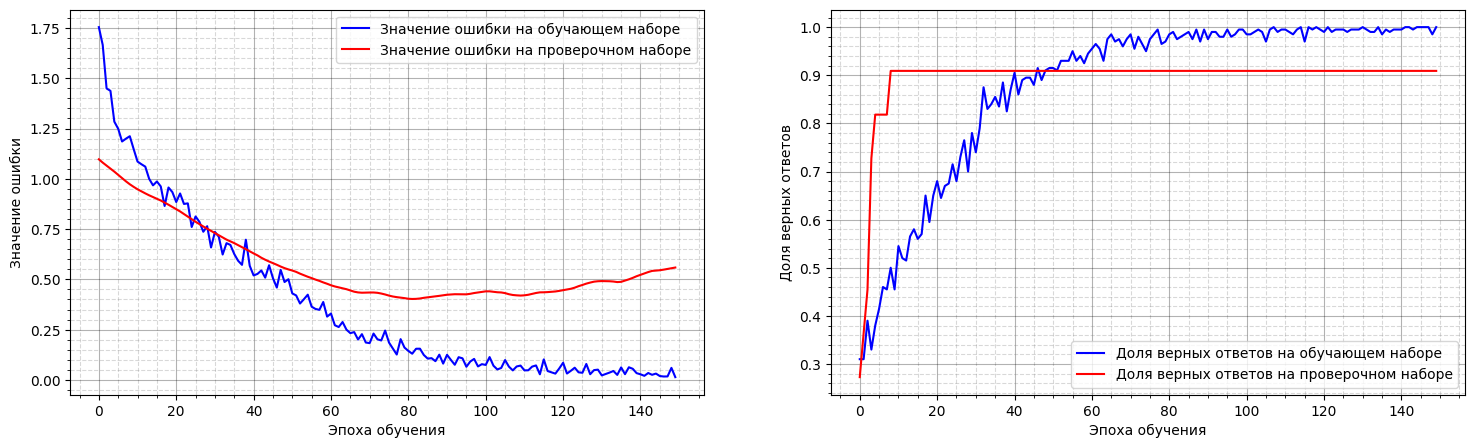

In [147]:
# Отобразим результаты на графике
printNNChart(history1)

In [148]:
# Оценим результат работы нашей сети.
# Применим метод .evaluate() к нашей модели, в качестве параметров
# передадим ему тестовые выборки и согласие на отображение хода вычисления.

scores1 = model1.evaluate(x_test,
                          y_test,
                          verbose=1)

print('Процент верных ответов на тестовых данных:', round(scores1[1],2) * 100, '%')

2/2 [==============================] - 0s 7ms/step - loss: 0.2971 - accuracy: 0.9211
Процент верных ответов на тестовых данных: 92.0 %


In [149]:
# Вывод значения точности распознавания на проверочной выборке по эпохам
print(f'Эпохи: {EPOCHS}')
print("="*50)

# val_accuracy
val_acc1 = history1.history['val_accuracy']
i_max = 0
val_acc_max = -1.0
for i in range(EPOCHS):
  # print(f'{i}->{EPOCHS}: {round(val_acc1[i], 3)}%')
  if val_acc1[i] > val_acc_max:
    val_acc_max = val_acc1[i]
    i_max = i

print(f'Самая точная нейронка под номером: {i_max} из {EPOCHS} эпох')
print(f'  достигла точности: {round(val_acc1[i]*100., 3)}%')

Эпохи: 150
Самая точная нейронка под номером: 8 из 150 эпох
  достигла точности: 90.909%


## F1Score - статистика предсказаний по тестовой выборке

In [150]:
# Распознавание ЗаключениеМК на тестовой выборке
# x_test, y_test -> массивы, которые не принимали участия в обучении нейронки
print('x_test, y_test -> массивы, которые не принимали участия в обучении нейронки:')
print('  x_test:')
print('    Количество осей: ',x_test.ndim)
print('    Форма массива: ',x_test.shape)
print('    Количество значений: ',x_test.size)
print('  y_test:')
print('    Количество осей: ',y_test.ndim)
print('    Форма массива: ',y_test.shape)
print('    Количество значений: ',y_test.size)

x_test, y_test -> массивы, которые не принимали участия в обучении нейронки:
  x_test:
    Количество осей:  2
    Форма массива:  (38, 847)
    Количество значений:  32186
  y_test:
    Количество осей:  2
    Форма массива:  (38, 3)
    Количество значений:  114


In [151]:
pred1 = model1.predict(x_test)

# У нас три класса:
# 0 - не годен, 1 - ограниченно годен, 2 - годен
# Подсчитаем по каждому верное и неверное предсказания
arr_true = np.zeros(3, dtype=int)
arr_false = np.zeros(3, dtype=int)

for i in range(y_test.shape[0]):
  # Получение индекса самого большого элемента
  # потому что мы имеем дело с one-hot-encoding, поэтому необходимо
  # определить элемент в массиве с максимальным значением,
  # индекс этого элемента и будет говорить о верном элементе
  #~индекс тестового элемента
  y_inx_max = np.argmax(y_test[i,:])
  #~индекс предсказанного элемента
  pred_inx_max = np.argmax(pred1[i,:])
  #~~~
  if y_inx_max == pred_inx_max:
    # верное предсказание
    arr_true[y_inx_max] += 1
  else:
    # неверное предсказания
    arr_false[y_inx_max] += 1

# Результаты предсказаний по тестовой выборке
print('Результаты предсказаний по тестовой выборке:')
print(f'  размер тествой выборки: {y_test.shape[0]}')
print(f'  0 - не годен, предсказания:')
print(f'     верное: {arr_true[0]}')
print(f'     неверное: {arr_false[0]}')
print(f'  1 - ограниченно годен, предсказания:')
print(f'     верное: {arr_true[1]}')
print(f'     неверное: {arr_false[1]}')
print(f'  2 - годен:')
print(f'     верное: {arr_true[2]}')
print(f'     неверное: {arr_false[2]}')

print('проверочная сумма:')

print(f'  {y_test.shape[0]} -> {arr_true[0]+arr_false[0]+arr_true[1]+arr_false[1]+arr_true[2]+arr_false[2]}')

2/2 [==============================] - 0s 5ms/step
Результаты предсказаний по тестовой выборке:
  размер тествой выборки: 38
  0 - не годен, предсказания:
     верное: 0
     неверное: 1
  1 - ограниченно годен, предсказания:
     верное: 0
     неверное: 1
  2 - годен:
     верное: 35
     неверное: 1
проверочная сумма:
  38 -> 38


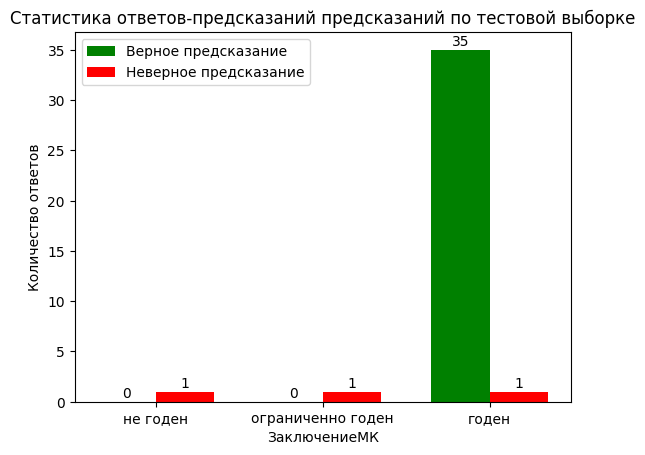

In [152]:
# conclusion_lst = ['не годен', 'ограниченно годен', 'годен']

fig, ax = plt.subplots()

index = np.arange(len(conclusion_lst))
bar_width = 0.35

rects1 = ax.bar(index, arr_true, bar_width, color='g', label='Верное предсказание')
rects2 = ax.bar(index + bar_width, arr_false, bar_width, color='r', label='Неверное предсказание')

ax.set_xlabel('ЗаключениеМК')
ax.set_ylabel('Количество ответов')
ax.set_title('Статистика ответов-предсказаний предсказаний по тестовой выборке')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(conclusion_lst)

ax.legend()

for rect, value in zip(rects1, arr_true):
    height = rect.get_height()
    ax.annotate('{}'.format(value),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for rect, value in zip(rects2, arr_false):
    height = rect.get_height()
    ax.annotate('{}'.format(value),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 1),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()

## Нейронка2 - категориальные+числовые (Модель FunctionalAPI-Составная нейронка)

# 2023.05.08 - 2023.06.26

In [ ]:
# print('y_data:')
# print('  Количество осей: ',y_data.ndim)
# print('  Форма массива: ',y_data.shape)
# print('  Количество значений: ',y_data.size)

# print('x1_data:')
# print('  Количество осей: ',x1_data.ndim)
# print('  Форма массива: ',x1_data.shape)
# print('  Количество значений: ',x1_data.size)

# print('x2_data:')
# print('  Количество осей: ',x2_data.ndim)
# print('  Форма массива: ',x2_data.shape)
# print('  Количество значений: ',x2_data.size)

# #~~~~~~~~~~~~~~~~~~~~~~~~
# input1 = Input((x1_data.shape[1],))
# input2 = Input((x2_data.shape[1],))

# #~~~~~~~~~~~~~~~~~~~~~~~~
# # Создаем ветку x1
# # x1 = BatchNormalization()(input1) # Создаем ветку x1
# # x1 = Dropout(0.5)(x1)
# # x1 = Dense(10, activation="relu")(x1)
# # x1 = Dense(1000, activation="relu")(x1)
# # x1 = Dense(100, activation = "relu")(x1)

# x1 = Dense(60, activation="relu")(input1)

# x1 = BatchNormalization()(x1)
# x1 = Dropout(0.2)(x1)
# x1 = Dense(30, activation="relu")(x1)

# x1 = BatchNormalization()(x1)
# x1 = Dropout(0.2)(x1)
# x1 = Dense(10, activation="relu")(x1)

# #~~~~~~~~~~~~~~~~~~~~~~~~
# # Создаем ветку x2
# x2 = Dense(60, activation="relu")(input2)

# x2 = BatchNormalization()(x2)
# x2 = Dropout(0.2)(x2)
# x2 = Dense(30, activation="relu")(x2)

# x2 = BatchNormalization()(x2)
# x2 = Dropout(0.2)(x2)
# x2 = Dense(10, activation="relu")(x2)

# #~~~~~~~~~~~~~~~~~~~~~~~~
# # Объединяем все две(три) ветки
# x = concatenate([x1, x2])
# x = Dense(5, activation='relu')(x)
# x = Dropout(0.5)(x)
# # Финальные нейроны
# x = Dense(3, activation='softmax')(x)

# #~~~~~~~~~~~~~~~~~~~~~~~~
# # В Model загружаем стартовые и последнюю точки
# model2 = Model((input1, input2), x)


y_data:
  Количество осей:  2
  Форма массива:  (3014, 3)
  Количество значений:  9042
x1_data:
  Количество осей:  2
  Форма массива:  (3014, 834)
  Количество значений:  2513676
x2_data:
  Количество осей:  2
  Форма массива:  (3014, 2)
  Количество значений:  6028


In [ ]:
# # Компиляция
# model2.compile(loss='categorical_crossentropy',
#                optimizer=Adam(learning_rate=LEARNING_RATE),
#                metrics=['accuracy'])

In [ ]:
# splitter90 = int(x1_data.shape[0]*(1. - VALID_DATA_SIZE))

# print(f'x1_data число строк : {x1_data.shape[0]}')
# print(f'x1_data число столбцов : {x1_data.shape[1]}')
# print(f'splitter90: {splitter90}')

x1_data число строк : 3014
x1_data число столбцов : 834
splitter90: 2863


In [153]:
# # history2 = model2.fit([xTrain01[:50000], xTrainRez01[:50000]],
# #                     yTrain[:50000],
# #                     epochs= 80,
# #                     validation_data=([xTrain01[50000:], xTrainRez01[50000:]],
# #                     yTrain[50000:]),
# #                     verbose=1, shuffle=True)

# history2 = model2.fit([x1_data[:splitter90], x2_data[:splitter90]],
#                       y_data[:splitter90],
#                       epochs= EPOCHS,
#                       validation_data=([x1_data[splitter90:], x2_data[splitter90:]],
#                       y_data[splitter90:]),
#                       verbose=VERBOSE)

In [154]:
# # Отобразим результаты на графике
# printNNChart(history2)

In [155]:
# # Вывод значения точности распознавания на проверочной выборке по эпохам
# print(f'Эпохи: {EPOCHS}')
# print("="*50)

# # val_accuracy
# val_acc2 = history2.history['val_accuracy']
# i_max = 0
# val_acc_max = -1.0
# for i in range(EPOCHS):
#   # print(f'{i}->{EPOCHS}: {round(val_acc1[i], 3)}%')
#   if val_acc2[i] > val_acc_max:
#     val_acc_max = val_acc2[2]
#     i_max = i

# print(f'Самая точная нейронка под номером: {i_max} из {EPOCHS} эпох')
# print(f'  достигла точности: {round(val_acc2[i]*100., 3)}%')